# 0: 下準備

## 0.1: ライブラリのインポート

In [6]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import cvxpy as cp
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats
import time
from attrdict import AttrDict
from matplotlib.dates import DateFormatter
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.api import VAR

## 0.2: データのインポート/作成

### 0.2.1: Tieckerデータの作成

In [8]:
# Tickerコードに".T"を末尾に追加
def convert_to_tickers_format(raw_tickers):
    ''' Raw tickersを対象フォーマットに変換 '''
    formatted_tickers = []
    for ticker in raw_tickers:
        if ticker == "^N225":
            formatted_tickers.append(ticker)
        else:
            formatted_tickers.append(ticker + '.T')
    return formatted_tickers

# Tickerコードと企業名を辞書形式で格納
def get_ticker_to_name_mapping(tickers):
    ''' Tickerの企業名の辞書を作成 '''
    ticker_to_name = {}
    for ticker in tickers:
        try:
            company_info = yf.Ticker(ticker)
            company_name = company_info.info["shortName"]
            ticker_to_name[ticker] = company_name
        except:
            ticker_to_name[ticker] = None
    return ticker_to_name

# Tickerコードのリストを作成
all_raw_tickers = [
    "1925", "1928", "2413", "2502", "2503", "2802", "2914", "3382", "3402", "3407", "4063", "4188", "4452", "4502", "4503", "4507", "4519", "4523", "4528", "4543", "4568", "4578", "4661", "4689", "4901", "4911", "5020", "5108", "5401", "5713", "5802", "6098", "6178", "6273", "6301", "6326", "6367", "6501", "6502", "6503", "6586", "6594", "6645", "6702", "6752", "6758", "6861", "6869", "6902", "6920", "6954", "6971", "6981", "7011", "7201", "7203", "7267", "7269", "7270", "7309", "7733", "7741", "7751", "7832", "7974", "8001", "8002", "8031", "8035", "8053", "8058", "8113", "8267", "8306", "8308", "8309", "8316", "8411", "8591", "8604", "8630", "8697", "8725", "8750", "8766", "8801", "8802", "8830", "9020", "9021", "9022", "9101", "9202", "9432", "9433", "9434", "9735", "9843", "9983", "9984", "^N225"
]

# 実行
all_tickers = convert_to_tickers_format(all_raw_tickers)
dict_ticker_to_name = get_ticker_to_name_mapping(all_tickers)

### 0.2.2: 株価データの作成

In [ ]:
# 定数の設定
YEARS_BACK = 10  # 取得するデータの期間を10年とする
INTERVALS = ["1mo", "1wk", "1d"]  # 取得するデータの間隔

# データの取得
def fetch_and_save_data(tickers, interval):
    ''' 指定されたティッカーと間隔に基づいてデータを取得し、CSVとして保存する '''
    result_df = pd.DataFrame()
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=YEARS_BACK)

    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
            result_df[ticker] = data["Close"]
        except Exception as e:
            print(f"Error fetching data for {ticker}. Error: {e}")

    result_df.reset_index(inplace=True)
    csv_filename = f"/Users/klynoaguilar/Desktop/01_school/Zemi/23_10_27_week-03/topix100_{interval}_data.csv"
    result_df.to_csv(csv_filename, index=False)
    print(f"Data fetching and saving for {interval} completed!")

# 実行
def main_making_data():
    for interval in INTERVALS:
        fetch_and_save_data(all_tickers, interval)
if __name__ == "__main__":
    main_making_data()

In [6]:
df_mo = pd.read_csv('./topix100_1mo_data.csv')
df_we = pd.read_csv('./topix100_1wk_data.csv')
df_da = pd.read_csv('./topix100_1d_data.csv')

#### 欠損値の確認/排除

In [7]:
def check_nan_values(df, df_name):
    """欠損値の確認関数"""
    print(f"Checking {df_name}...")
    for column in df.columns:
        nan_count = df[column].isnull().sum()
        if nan_count > 0:
            print(f"Column '{column}' has {nan_count} NaN values.")
print('------\n')

print('-------- 欠損値の確認 --------')
check_nan_values(df_mo, 'df_mo')
check_nan_values(df_we, 'df_we')
check_nan_values(df_da, 'df_da')

print('-------- 欠損値が多い列の排除 --------')
# 排除したい列のリスト
columns_to_drop = ['6098.T', '6178.T', '9434.T']
df_mo = df_mo.drop(columns=columns_to_drop)
df_we = df_we.drop(columns=columns_to_drop)
df_da = df_da.drop(columns=columns_to_drop)


print('-------- 欠損値の確認 --------')
check_nan_values(df_mo, 'df_mo')
check_nan_values(df_we, 'df_we')
check_nan_values(df_da, 'df_da')

-------- 欠損値の確認 --------
Checking df_mo...
Column '6098.T' has 12 NaN values.
Column '6178.T' has 25 NaN values.
Column '9434.T' has 62 NaN values.
------

Checking df_we...
Column '6098.T' has 51 NaN values.
Column '6178.T' has 106 NaN values.
Column '9434.T' has 269 NaN values.
Column '^N225' has 1 NaN values.
------

Checking df_da...
Column '6098.T' has 242 NaN values.
Column '6178.T' has 498 NaN values.
Column '9434.T' has 1287 NaN values.
Column '^N225' has 21 NaN values.
------

-------- 欠損値が多い列の排除 --------
-------- 欠損値の確認 --------
Checking df_mo...
------

Checking df_we...
Column '^N225' has 1 NaN values.
------

Checking df_da...
Column '^N225' has 21 NaN values.
------



### 0.2.3: データの分類/作成

In [8]:
construction_real_estate = [
  '1925.T', '1928.T', '8801.T', '8802.T', '8830.T'
  ]
food_beverage = [
  '2502.T', '2503.T', '2802.T', '2914.T'
  ]
retail = [
  '3382.T', '8267.T', '9843.T', '9983.T'
  ]
chemicals_pharmaceuticals = ['3402.T', '3407.T', '4063.T', '4188.T', '4452.T', '4502.T', '4503.T', '4507.T', '4519.T', '4523.T', '4528.T', '4568.T', '4578.T', '4901.T', '8113.T', '4911.T']
finance_insurance = ['8306.T', '8308.T', '8309.T', '8316.T', '8411.T', '8591.T', '8604.T', '8630.T', '8697.T', '8725.T', '8750.T', '8766.T']
information_communication = ['4689.T', '9432.T', '9433.T', '9984.T']
transport_logistics = ['9101.T', '9202.T', '9020.T', '9021.T', '9022.T']
materials = ['5401.T', '5713.T', '5020.T', '5108.T']
machinery_electronics = ['6301.T', '6326.T', '6367.T', '6501.T', '6502.T', '6503.T', '6586.T', '6594.T', '6645.T', '6702.T', '6752.T', '6758.T', '6861.T', '6902.T', '5802.T', '6869.T', '6920.T', '6971.T', '6981.T', '7011.T', '6273.T', '8035.T']
automotive_transport_equipment = ['7201.T', '7203.T', '7267.T', '7269.T', '7270.T']
trading_companies = ['8001.T', '8002.T', '8031.T', '8053.T', '8058.T']
healthcare_medical_equipment = ['4543.T', '6954.T', '7733.T', '7741.T', '7751.T', '2413.T']
services_entertainment = ['4661.T', '7309.T', '7832.T', '7974.T', '9735.T']
markets = ['^N225']

In [90]:
ALL_DATA = {
    'tickers': {
        'all_tc': {
            'tc_all_raw': all_raw_tickers,
            'tc_all_formatted': all_tickers,
            'tc_dict_ticker_to_company_name': dict_ticker_to_name
        },
        'category_tc': {
            'construction_real_estate': construction_real_estate,
            'food_beverage': food_beverage,
            'retail': retail,
            'chemicals_pharmaceuticals' : chemicals_pharmaceuticals,
            'finance_insurance': finance_insurance,
            'information_communication': information_communication,
            'transport_logistics': transport_logistics,
            'materials': materials,
            'machinery_electronics': machinery_electronics,
            'automotive_transport_equipment': automotive_transport_equipment,
            'trading_companies': trading_companies, 
            'healthcare_medical_equipment': healthcare_medical_equipment,
            'services_entertainment': services_entertainment,
            'markets': markets,
        }
    },
    'dataframe': {
        'all_df': {
            'df_mo': df_mo,
            'df_we': df_we,
            'df_da': df_da
        },
        'category_df': {
            'df_mo': {
                # '''この中に業界ごとのデータフレームが格納'''
                },
            'df_we': {
                # '''この中に業界ごとのデータフレームが格納'''
                },
            'df_da': {
                # '''この中に業界ごとのデータフレームが格納'''
                },
        }
    }
}

In [91]:
for key in ALL_DATA['dataframe']['all_df'].keys():
    for category, tickers in ALL_DATA['tickers']['category_tc'].items():
        # 空のDataFrameを作成
        temp_df = pd.DataFrame()

        # Dateを追加
        temp_df['Date'] = ALL_DATA['dataframe']['all_df'][key]['Date']

        # tickersに該当するカラムを取り出す
        for ticker in tickers:
            temp_df[ticker] = ALL_DATA['dataframe']['all_df'][key][ticker]

        # その結果をcategory_dfに格納
        ALL_DATA['dataframe']['category_df'][key][category] = temp_df

In [92]:
def print_nested_dict_keys(data_dict, depth=0, max_subkeys=3):
    """Prints keys from nested dictionary with indentation."""
    indent = "    " * depth
    for idx, key in enumerate(data_dict.keys()):
        if idx >= max_subkeys and depth != 0:  # Do not limit the top-level keys
            break
        print(f"{indent}{key}")
        if isinstance(data_dict[key], dict):
            print_nested_dict_keys(data_dict[key], depth+1)

# 使用例
print_nested_dict_keys(ALL_DATA)

tickers
    all_tc
        tc_all_raw
        tc_all_formatted
        tc_dict_ticker_to_company_name
            1925.T
            1928.T
            2413.T
    category_tc
        construction_real_estate
        food_beverage
        retail
dataframe
    all_df
        df_mo
        df_we
        df_da
    category_df
        df_mo
            construction_real_estate
            food_beverage
            retail
        df_we
            construction_real_estate
            food_beverage
            retail
        df_da
            construction_real_estate
            food_beverage
            retail


### 0.2.X: その他設定事項

In [93]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

# 1: データ分析

## 1.1: 関数のまとめ

In [197]:
'''---- 線形グラフの表示 ---'''
def plot_stock_prices(title, dataframe, selected_columns, figsize=(20, 6)):
    """
    Plot stock prices from a dataframe.
    
    Parameters:
    - title: str, the title of the plot.
    - dataframe: pd.DataFrame containing date and stock prices.
    - selected_columns: list, the column names of stock prices to be plotted.
    - figsize: tuple, size of the figure to plot.
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Assuming the Date column is always named 'Date'
    for column in selected_columns:
        ax.plot(dataframe["Date"], dataframe[column], label=column)

    ax.set_title(f'Stock Price over Time({title})')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    
    # y軸の横の線を点線に設定し、x軸の縦線を削除
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, axis="y")
    ax.grid(False, axis="x")  # x軸の縦線を消す
    
    # グラフの周りの四角い線を灰色に設定
    for spine in ax.spines.values():
        spine.set_color('gray')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=12))
    
    plt.style.use('_mpl-gallery')
    plt.tight_layout()
    plt.show()

# 使用例
# selected_columns = ["Stock1", "Stock2"]
# plot_stock_prices('title', dataframe, selected_columns)



'''---- ポートフォリオ作成 ----'''
def calculate_efficient_frontier(temp_data, selected):
    # calculate daily and annual returns of the stocks
    returns_monthly = temp_data.pct_change()
    returns_annual = returns_monthly.mean() * 12

    # get daily and covariance of returns of the stock
    cov_monthly = returns_monthly.cov()
    cov_annual = cov_monthly * 12

    # 日本国債のリスクフリーレート
    rf_rate = 0.008

    # empty lists to store returns, volatility and weights of imaginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = 5000

    np.random.seed(101)

    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = (returns - rf_rate) / volatility  # シャープレシオの計算を修正
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

    portfolio = {'Returns': port_returns,
                'Volatility': port_volatility,
                'Sharpe Ratio': sharpe_ratio}

    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    df = pd.DataFrame(portfolio)
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]
    df = df[column_order]

    # 最大シャープレシオを持つポートフォリオを探す
    max_sharpe = df['Sharpe Ratio'].max()
    min_volatility = df['Volatility'].min()
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]

    print(sharpe_portfolio.T)
    print(min_variance_port.T)

    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200)
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier with Tangent Portfolio')
    plt.show()
# 使用例:
# calculate_efficient_frontier(temp_data, selected)



'''---- ADF検定 ----'''
def perform_adf_test(title, series, alpha=0.05):
    """
    Conduct the Augmented Dickey-Fuller test for stationarity of a time series and display the results in a table format.
    
    Parameters:
    - series: pd.Series, the time series data to be tested.
    - alpha: float, significance level for the test.

    Returns:
    - pd.DataFrame, table with the test results.
    """
    result = adfuller(series, autolag='AIC')
    
    # Extracting the test results
    test_statistic = result[0]
    p_value = result[1]
    lags_used = result[2]
    nobs = result[3]
    critical_values = result[4]
    
    # Creating a DataFrame to display the results
    result_df = pd.DataFrame({
        "ADF Test Statistic": [test_statistic],
        "P-Value": [p_value],
        "# Lags Used": [lags_used],
        "# Observations": [nobs]
    })
    
    # Adding critical values to the dataframe
    for key, value in critical_values.items():
        result_df[f'Critical Value ({key})'] = value
    
    # Adding the result
    result_df["Result"] = ["Stationary" if p_value <= alpha else "Not Stationary"]
    
    # Setting the title as an index for better visualization
    result_df.index = [title]
    
    return result_df

# Example usage:
# series = pd.Series(data)
# df_result = perform_adf_test("Test Series", series)
# display(df_result)


'''---- トレンド非定常性の排除：差分 ----'''
def remove_trend(data) -> pd.DataFrame:
    """
    Apply differencing and drop NaN rows to remove trend non-stationarity from time series data.
    
    Parameters:
    - data: pd.Series or pd.DataFrame, the input data with one or more time series columns.

    Returns:
    - pd.Series or pd.DataFrame, the transformed data with trend non-stationarity removed.
    """
    
    if isinstance(data, pd.Series):
        data_copy = data.copy()
        return data_copy.diff().dropna()
    
    elif isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        
        # List all columns except 'Date'
        cols_to_diff = [col for col in data_copy.columns if col != 'Date']
        
        # Apply diff() for each column except 'Date'
        for col in cols_to_diff:
            data_copy[col] = data_copy[col].diff()
        
        # Drop rows with NaN values
        return data_copy.dropna()
    
    else:
        raise ValueError("Input data must be a pandas DataFrame or Series")



'''---- トレンド非定常性の排除：対数差分 ----'''
def log_difference(data, selected_columns=None) -> pd.DataFrame:
    """
    Compute the log difference for a given DataFrame or Series.
    
    Parameters:
    - data: pd.DataFrame or pd.Series, the input data with one or more time series columns.
    - selected_columns: list, the columns for which the log difference should be computed.
                    If None, it computes for all columns (except 'Date' if present).

    Returns:
    - pd.DataFrame or pd.Series, the log difference of the original data.
    """
    
    # If data is a Series
    if isinstance(data, pd.Series):
        return np.log(data).diff().dropna()
    
    # If data is a DataFrame
    elif isinstance(data, pd.DataFrame):
        
        # If no specific columns are selected, select all columns except 'Date'
        if selected_columns is None:
            selected_columns = [col for col in data.columns if col != 'Date']
        
        # Apply log difference for each selected column
        for col in selected_columns:
            data[col] = np.log(data[col]).diff()
        
        return data.dropna()
    
    else:
        raise ValueError("Input data must be a pandas DataFrame or Series")

# Example usage
# df_log_diff = log_difference(dataframe, ['Column1', 'Column2'])


'''---- VARモデル -----'''
def create_var_model(data, lags=None):
    """
    データフレームを入力として受け取り、指定されたラグ数でVARモデルをフィットさせる関数
    
    Parameters:
    - data (pd.DataFrame): 多変量の時系列データ
    - lags (int, optional): モデルに使用するラグ数。指定されていない場合、自動的に選択されます。
    
    Returns:
    - model: フィットされたVARモデル
    """

    model = VAR(data)
    
    if lags:
        result = model.fit(lags)
    else:
        result = model.fit(maxlags=12, ic='aic')  # maxlagsと情報量基準(ic)を指定して自動的にラグ数を選択

    return result

# 例:
# data = pd.DataFrame({
#     'y1': np.random.randn(100),
#     'y2': np.random.randn(100)
# })
# fitted_model = create_var_model(data)
# print(fitted_model.summary())

'''---- VARモデルでの予測 ----'''
def plot_var_forecast_for_target(data, target='7203.T', forecast_steps=10, lags=None):
    """
    VARモデルを用いて特定のターゲット変数の予測をグラフで表示する関数
    
    Parameters:
    - data (pd.DataFrame): VARモデルの入力データ
    - target (str): 予測対象のカラム名
    - forecast_steps (int): 予測を行うステップ数
    
    Returns:
    None (グラフを表示する)
    """
    
    # VARモデルをデータに適用
    model = VAR(data)
    if lags:
        fitted_model = model.fit(lags)
    else:
        fitted_model = model.fit(maxlags=12, ic='aic')  # maxlagsと情報量基準(ic)を指定して自動的にラグ数を選択
    fitted_model = model.fit()

    # 予測の生成
    forecast = fitted_model.forecast(data.values[-fitted_model.k_ar:], steps=forecast_steps)
    forecast_df = pd.DataFrame(forecast, columns=data.columns)

    # 予測結果のグラフ表示
    plt.figure(figsize=(10, 6))
    plt.plot(data[target], label='Actual', color='blue')
    plt.plot(np.arange(len(data), len(data) + forecast_steps), forecast_df[target], label='Forecast', color='red')
    plt.title(f'Forecast for {target}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 使用例:
# data = pd.DataFrame({
#     '7203.T': np.random.randn(100),
#     '7201.T': np.random.randn(100)
# })
# plot_var_forecast_for_target(data, target='7203.T', forecast_steps=30)

In [95]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## 1.2: 線グラフの表示

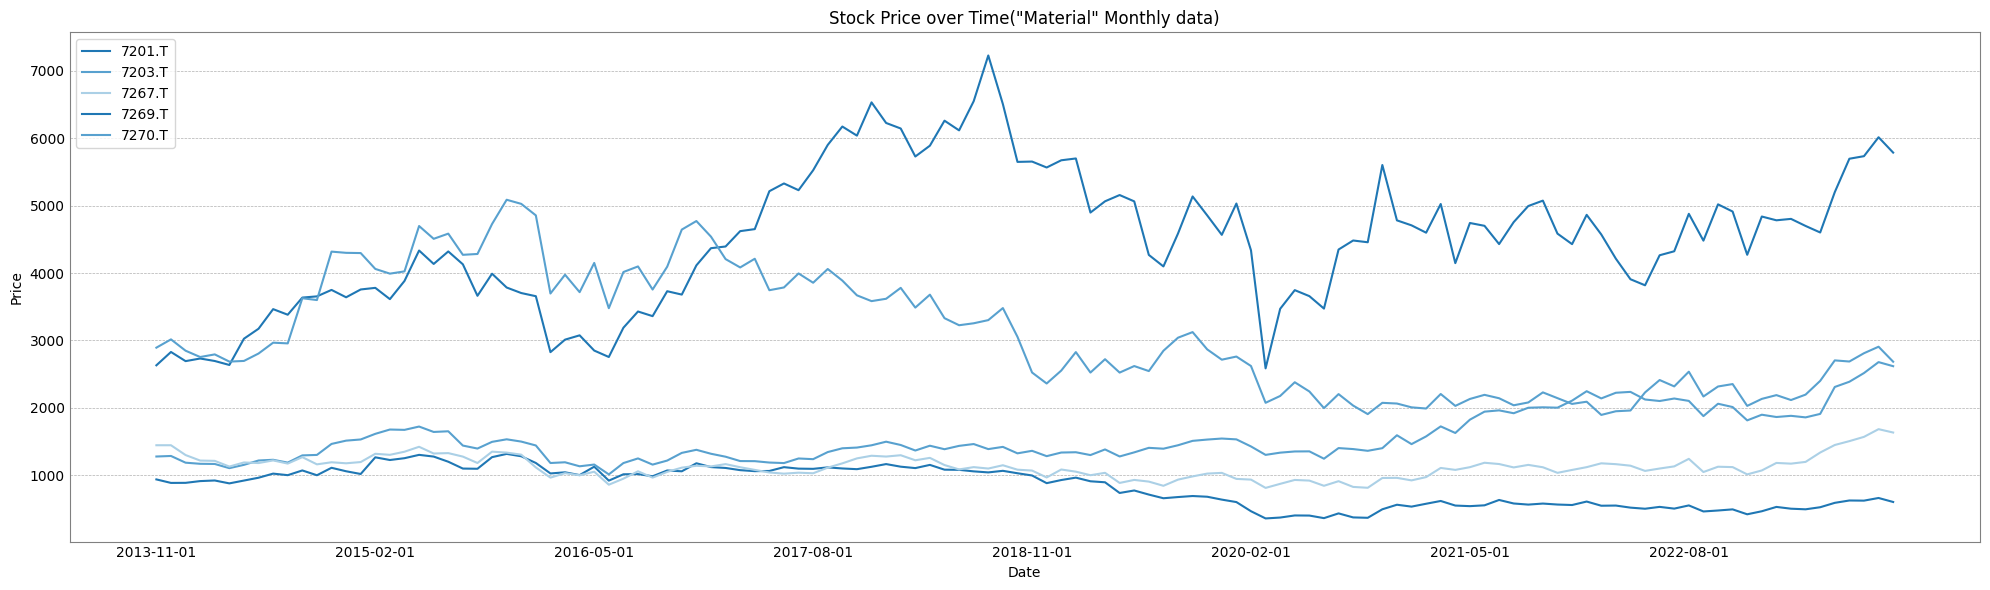

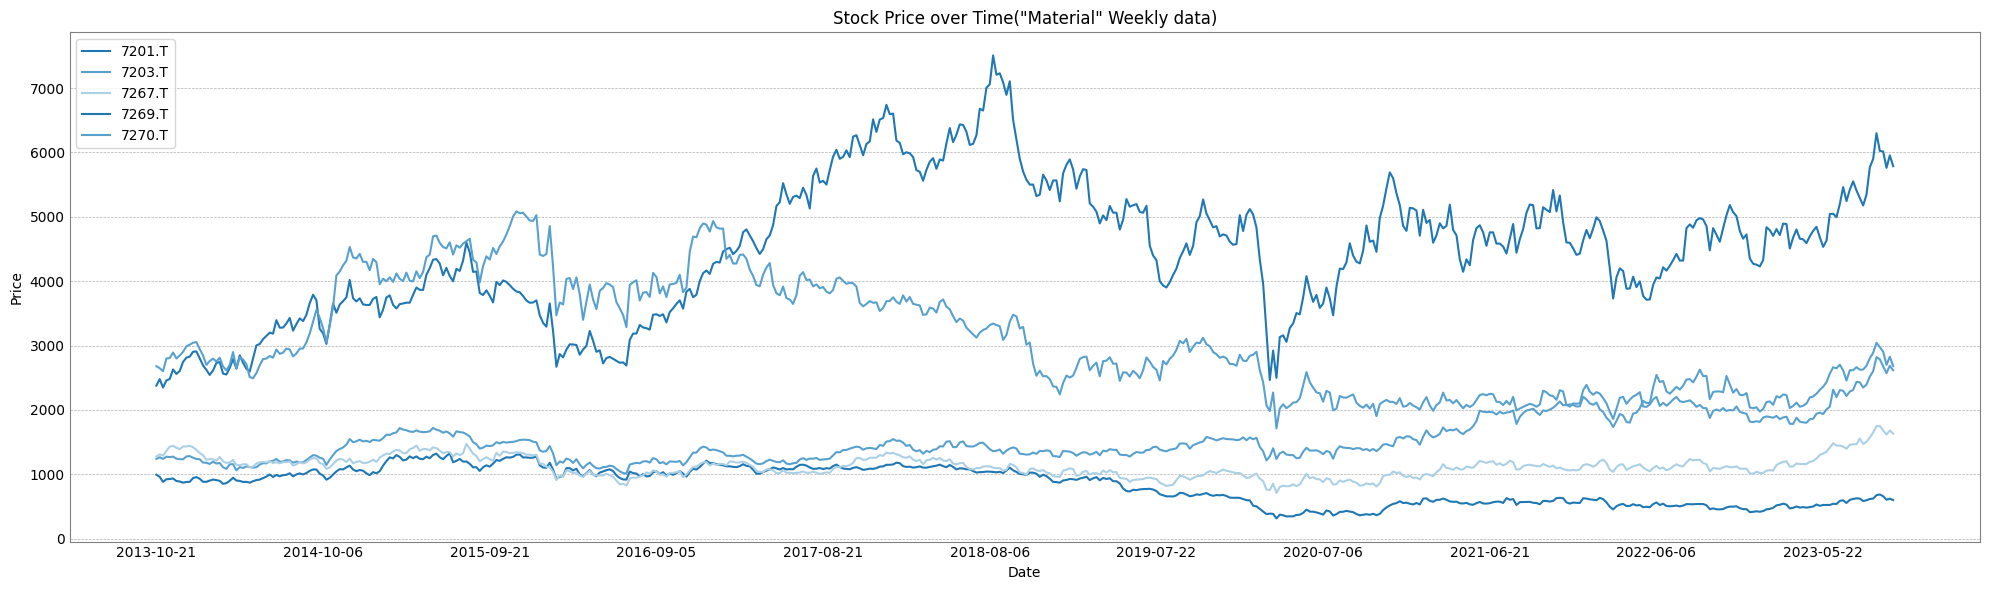

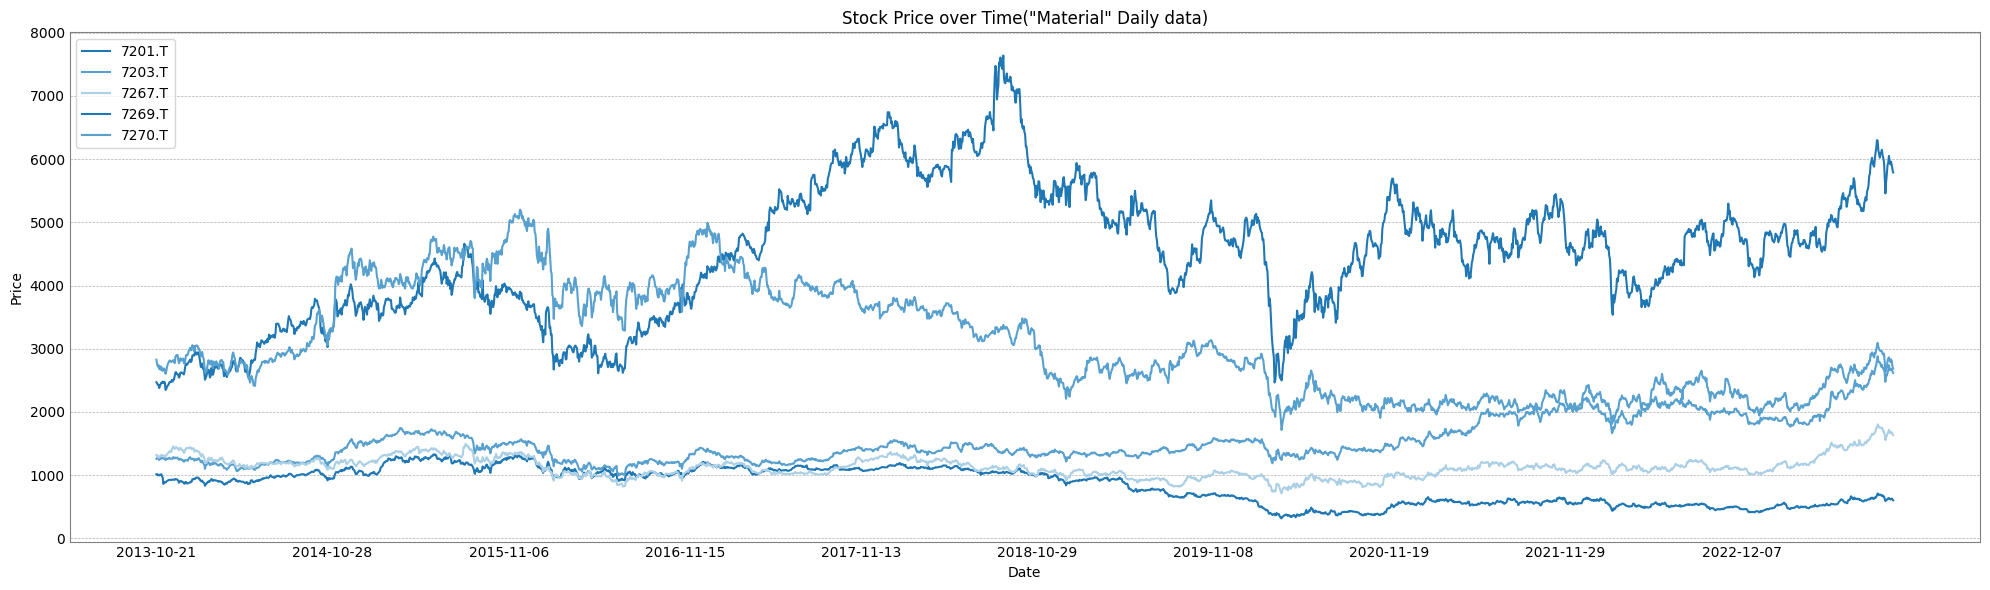

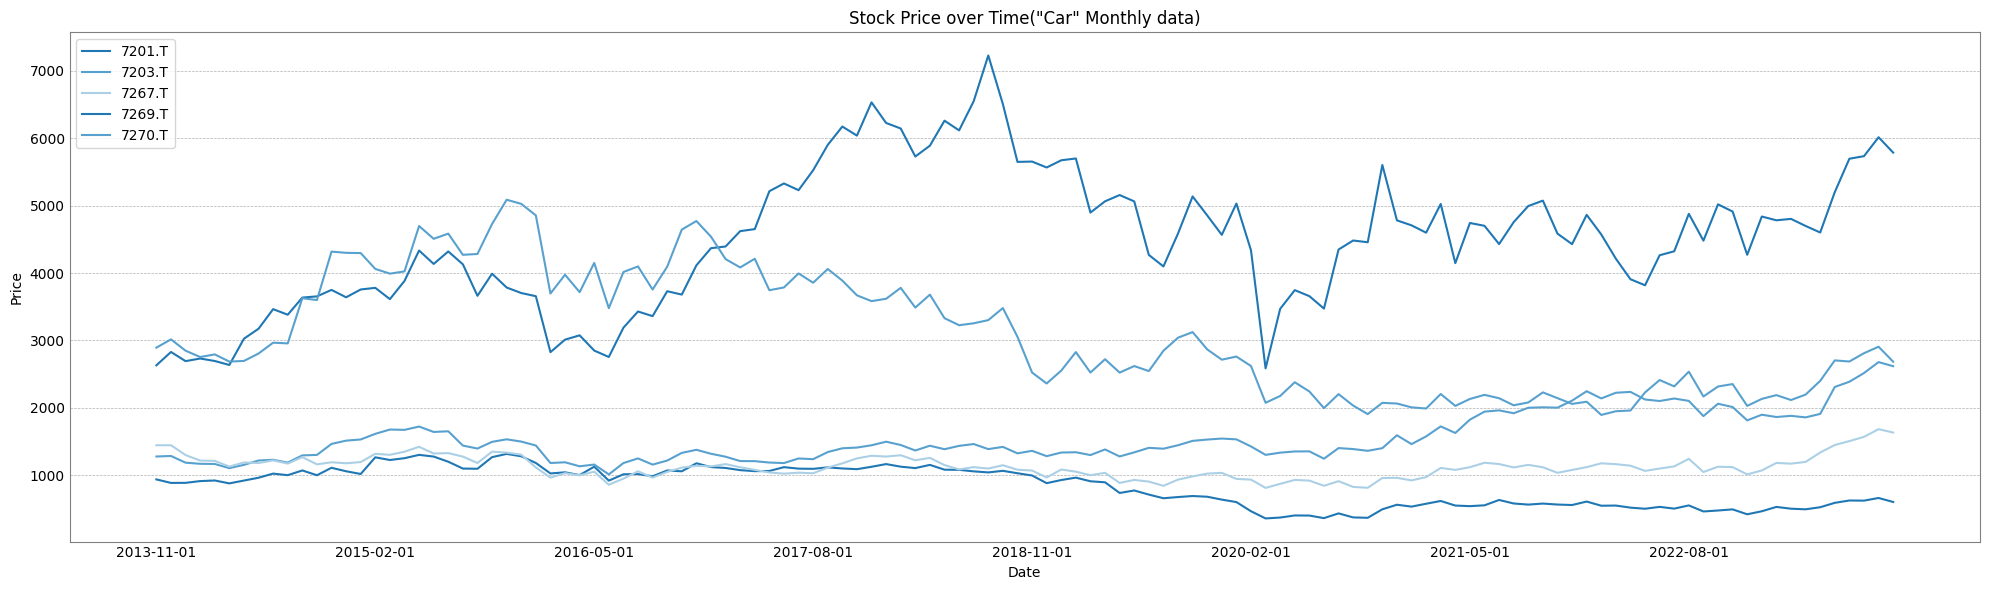

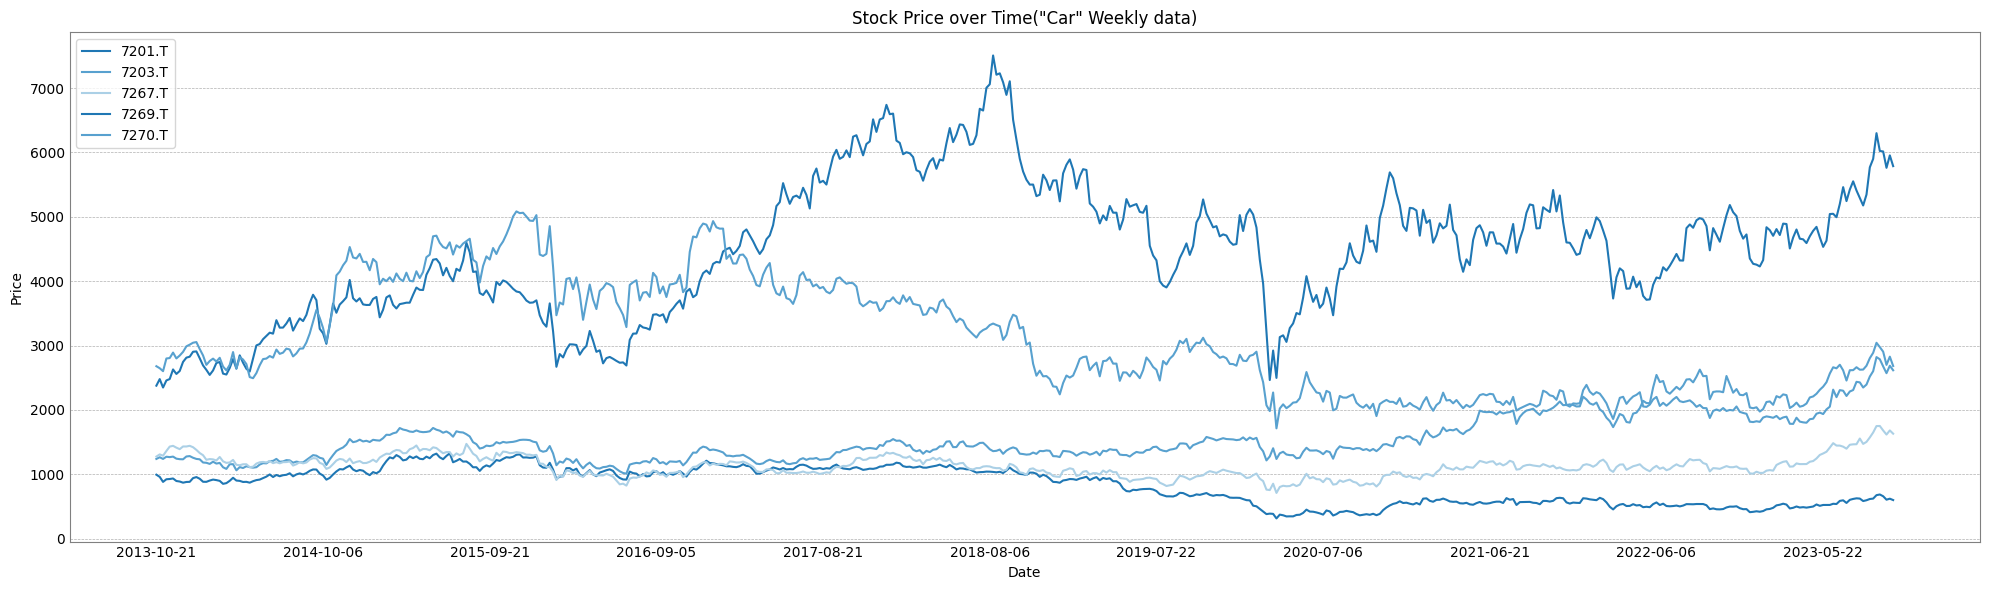

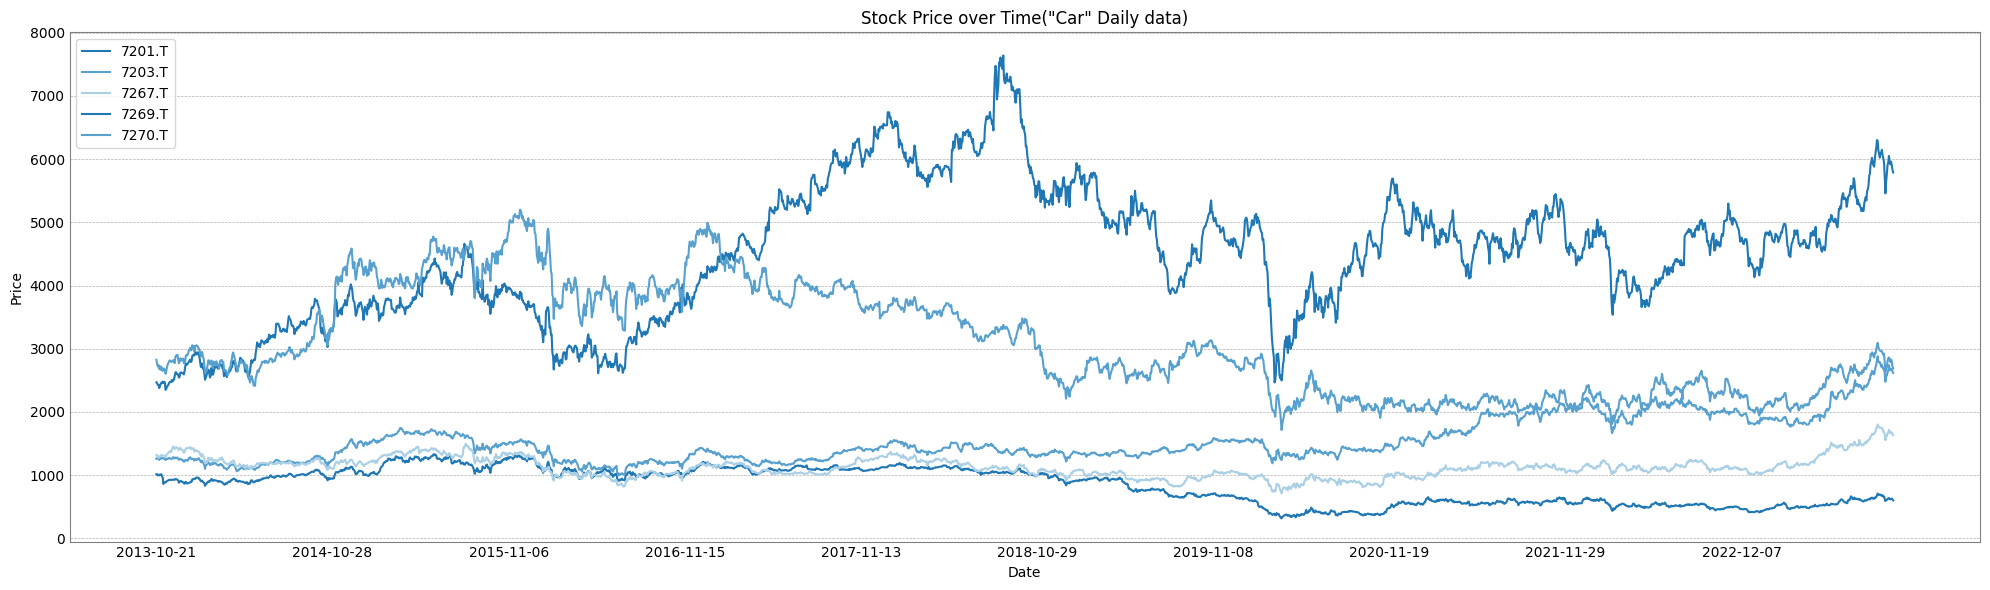

In [96]:
_temp_car_ticker = ALL_DATA['tickers']['category_tc']['automotive_transport_equipment']
_temp_material_ticker = ALL_DATA['tickers']['category_tc']['materials']


plot_stock_prices('"Material" Monthly data', df_mo, ALL_DATA['tickers']['category_tc']['automotive_transport_equipment'])
print('\n')
plot_stock_prices('"Material" Weekly data', df_we, ALL_DATA['tickers']['category_tc']['automotive_transport_equipment'])
print('\n')
plot_stock_prices('"Material" Daily data', df_da, ALL_DATA['tickers']['category_tc']['automotive_transport_equipment'])
print('\n')
plot_stock_prices('"Car" Monthly data', df_mo, df_mo[_temp_car_ticker])
print('\n')
plot_stock_prices('"Car" Weekly data', df_we, df_we[_temp_car_ticker])
print('\n')
plot_stock_prices('"Car" Daily data', df_da,  df_da[_temp_car_ticker])
print('\n')

## 1.3: データの概要把握

In [97]:
print(ALL_DATA['dataframe']['category_df']['df_mo']['automotive_transport_equipment'].describe())


            7201.T       7203.T       7267.T       7269.T       7270.T
count   120.000000   120.000000   120.000000   120.000000   120.000000
mean    830.218334  1548.396668  1125.406946  4492.904167  3078.970833
std     281.896369   359.357850   167.579426  1024.756465   888.342852
min     356.600006  1010.400024   810.000000  2584.500000  1893.500000
25%     554.674988  1296.200012  1025.833328  3723.250000  2227.875000
50%     909.600006  1429.700012  1117.333313  4482.000000  2836.250000
75%    1074.625000  1745.524963  1199.833344  5090.500000  3803.500000
max    1314.500000  2677.500000  1682.000000  7230.000000  5088.000000


ポートフォリオ作成

In [98]:
ALL_DATA['tickers']['category_tc']['materials']

['5401.T', '5713.T', '5020.T', '5108.T']

                   1428
Returns        0.106476
Volatility     0.230492
Sharpe Ratio   0.427244
NISSAN Weight  0.026718
TOYOTA Weight  0.440695
HONDA Weight   0.031272
SUZUKI Weight  0.455535
SUBARU Weight  0.045780
                   4370
Returns        0.088503
Volatility     0.203935
Sharpe Ratio   0.394747
NISSAN Weight  0.006998
TOYOTA Weight  0.635765
HONDA Weight   0.202010
SUZUKI Weight  0.145285
SUBARU Weight  0.009942


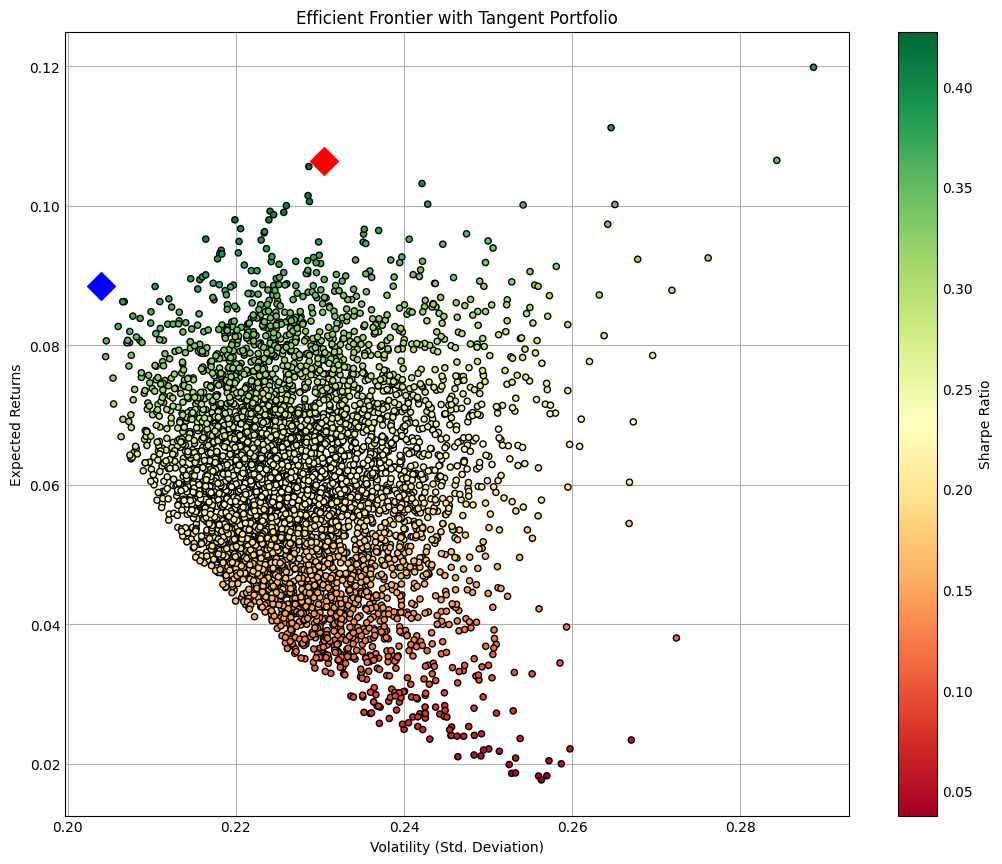



                   1428
Returns        0.026954
Volatility     0.123582
Sharpe Ratio   0.153371
NISSAN Weight  0.026718
TOYOTA Weight  0.440695
HONDA Weight   0.031272
SUZUKI Weight  0.455535
SUBARU Weight  0.045780
                   3585
Returns        0.020674
Volatility     0.113857
Sharpe Ratio   0.111312
NISSAN Weight  0.076181
TOYOTA Weight  0.660531
HONDA Weight   0.184872
SUZUKI Weight  0.056844
SUBARU Weight  0.021573


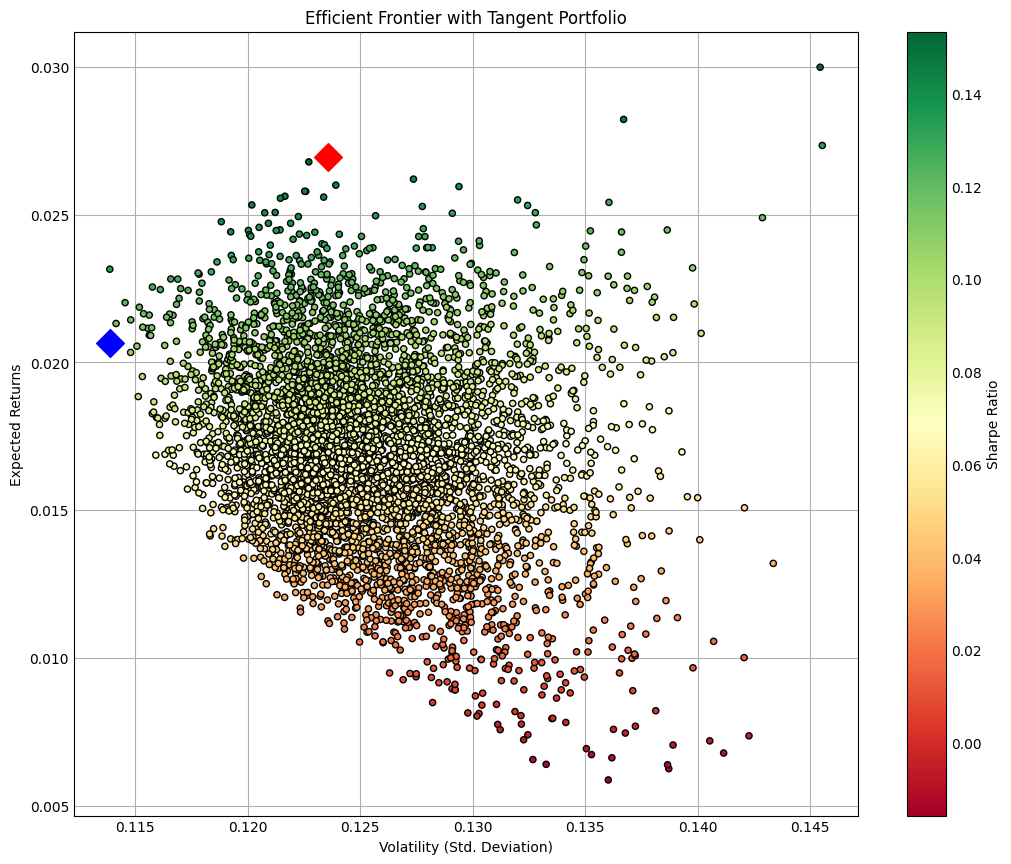



                   3296
Returns        0.006004
Volatility     0.064643
Sharpe Ratio  -0.030884
NISSAN Weight  0.041435
TOYOTA Weight  0.111817
HONDA Weight   0.039559
SUZUKI Weight  0.784518
SUBARU Weight  0.022671
                   4886
Returns        0.004371
Volatility     0.051989
Sharpe Ratio  -0.069802
NISSAN Weight  0.058503
TOYOTA Weight  0.598741
HONDA Weight   0.197817
SUZUKI Weight  0.108818
SUBARU Weight  0.036120


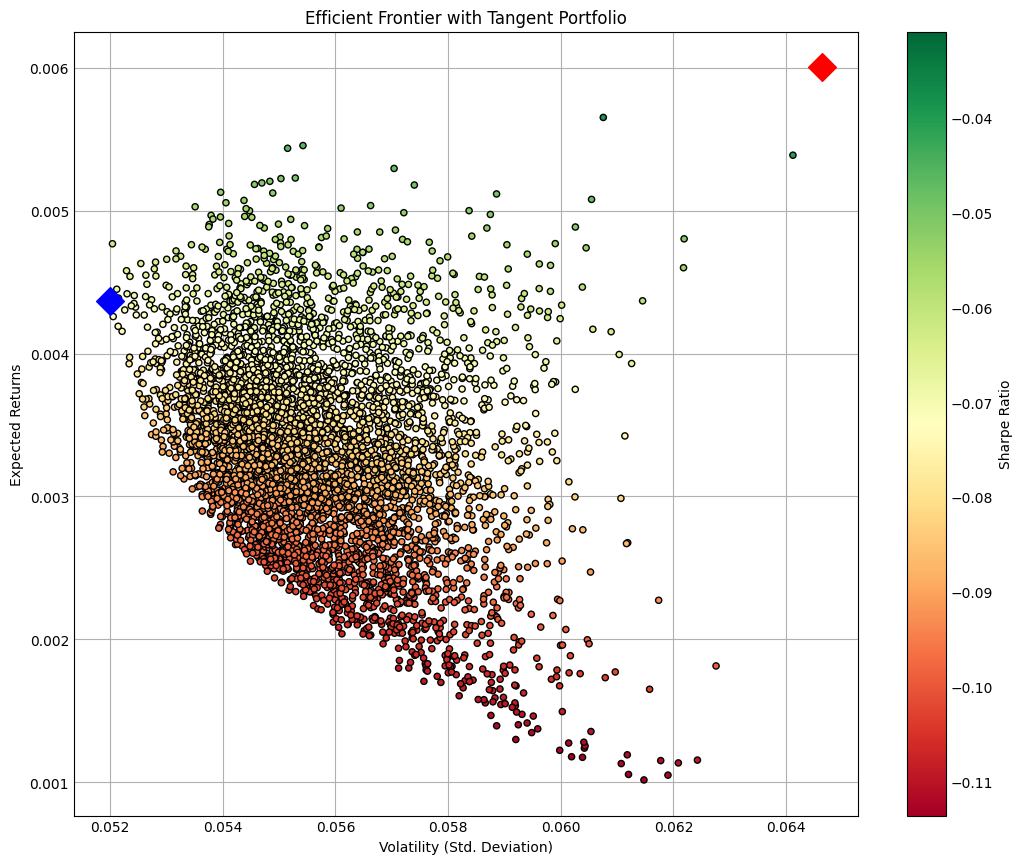



                    643
Returns        0.077090
Volatility     0.207442
Sharpe Ratio   0.333056
日本製鐵 Weight    0.019030
住友金属鉱山 Weight  0.395456
ENEOS Weight   0.017559
ブリジストン Weight  0.567955
                   2943
Returns        0.058324
Volatility     0.184535
Sharpe Ratio   0.272707
日本製鐵 Weight    0.007860
住友金属鉱山 Weight  0.075583
ENEOS Weight   0.327384
ブリジストン Weight  0.589173


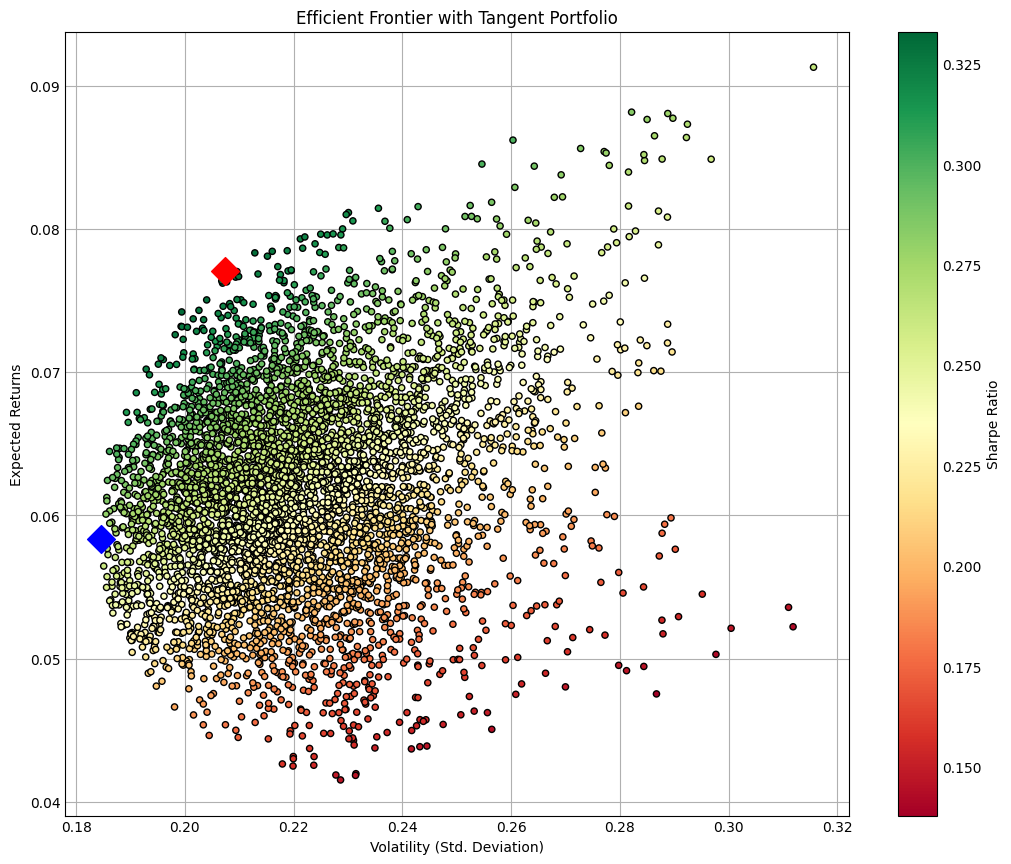



                    643
Returns        0.021323
Volatility     0.118279
Sharpe Ratio   0.112643
日本製鐵 Weight    0.019030
住友金属鉱山 Weight  0.395456
ENEOS Weight   0.017559
ブリジストン Weight  0.567955
                   4817
Returns        0.016973
Volatility     0.104619
Sharpe Ratio   0.085774
日本製鐵 Weight    0.010783
住友金属鉱山 Weight  0.044475
ENEOS Weight   0.356457
ブリジストン Weight  0.588285


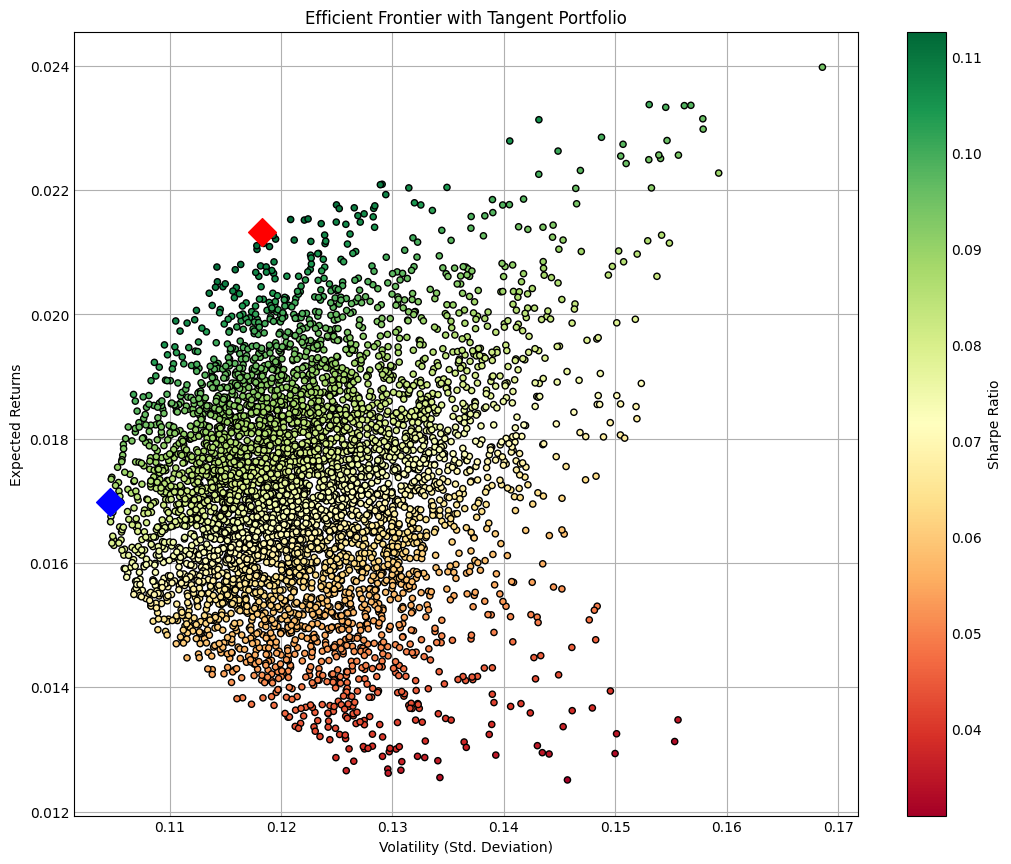



                   2329
Returns        0.004662
Volatility     0.072006
Sharpe Ratio  -0.046352
日本製鐵 Weight    0.042407
住友金属鉱山 Weight  0.913218
ENEOS Weight   0.040182
ブリジストン Weight  0.004193
                   3277
Returns        0.003365
Volatility     0.046885
Sharpe Ratio  -0.098851
日本製鐵 Weight    0.004688
住友金属鉱山 Weight  0.033005
ENEOS Weight   0.397371
ブリジストン Weight  0.564936


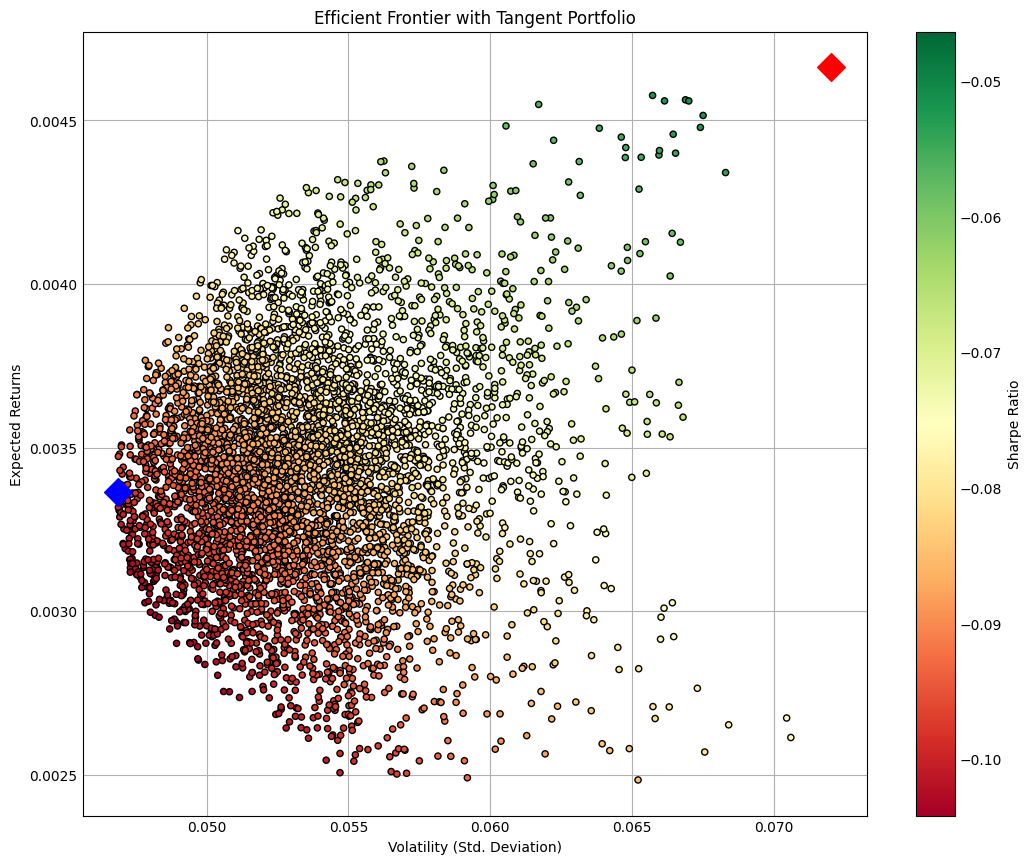

In [99]:
_temp_car_data = ALL_DATA['tickers']['category_tc']['automotive_transport_equipment']
_temp_material_data = ALL_DATA['tickers']['category_tc']['materials']
_temp_car_name = ['NISSAN', 'TOYOTA', 'HONDA','SUZUKI', 'SUBARU']
_temp_material_name = ['日本製鐵', '住友金属鉱山', 'ENEOS', 'ブリジストン']

calculate_efficient_frontier(df_mo[_temp_car_data], _temp_car_name)
print('\n')
calculate_efficient_frontier(df_we[_temp_car_data], _temp_car_name)
print('\n')
calculate_efficient_frontier(df_da[_temp_car_data], _temp_car_name)
print('\n')

calculate_efficient_frontier(df_mo[_temp_material_data], _temp_material_name)
print('\n')
calculate_efficient_frontier(df_we[_temp_material_data], _temp_material_name)
print('\n')
calculate_efficient_frontier(df_da[_temp_material_data], _temp_material_name)
print('\n')

ポートフォリオデータの作成

In [100]:
ALL_DATA['tickers']['category_tc']['materials']

['5401.T', '5713.T', '5020.T', '5108.T']

In [115]:
_temp_mo = df_mo.copy()
_temp_we = df_we.copy()
_temp_da = df_da.copy()

df_mo_po = pd.DataFrame()
df_we_po = pd.DataFrame()
df_da_po = pd.DataFrame()

df_mo_po['Date'] = _temp_mo['Date'].copy()
df_mo_po['po_car'] = (_temp_mo['7201.T']*0.026718 + _temp_mo['7203.T']*0.440695 + _temp_mo['7267.T']*0.026718 + _temp_mo['7269.T']*0.455535 +_temp_mo['7270.T']*0.045780)
df_mo_po['po_material'] = (_temp_mo['5401.T']*0.019030 + _temp_mo['5713.T']*0.395456 + _temp_mo['5020.T']*0.017559 + _temp_mo['5108.T']*0.567955)

df_we_po['Date'] = _temp_we['Date'].copy()
df_we_po['po_car'] = (_temp_we['7201.T']*0.026718 + _temp_we['7203.T']*0.440695 + _temp_we['7267.T']*0.031272 + _temp_we['7269.T']*0.455535 +_temp_we['7270.T']*0.045780)
df_we_po['po_material'] = (_temp_we['5401.T']*0.019030 + _temp_we['5713.T']*0.395456 + _temp_we['5020.T']*0.017559 + _temp_we['5108.T']*0.567955)

df_da_po['Date'] = _temp_da['Date'].copy()
df_da_po['po_car'] = (_temp_da['7201.T']*0.041435 + _temp_da['7203.T']*0.111817 + _temp_da['7267.T']*0.039559 + _temp_da['7269.T']*0.784518 +_temp_da['7270.T']*0.022671)
df_da_po['po_material'] = (_temp_da['5401.T']*0.042407 + _temp_da['5713.T']*0.913218 + _temp_da['5020.T']*0.040182 + _temp_da['5108.T']*0.004193)

print(df_mo_po.describe())
print('------------')
print(df_we_po.describe())
print('------------')
print(df_da_po.describe())

            po_car  po_material
count   120.000000   120.000000
mean   2922.251450  4018.760317
std     529.894602   660.716514
min    1862.962692  2714.359401
25%    2604.741560  3475.836861
50%    2971.150657  3908.655648
75%    3262.121832  4565.787902
max    4116.077674  5361.050888
------------
            po_car  po_material
count   522.000000   522.000000
mean   2918.168596  4011.754492
std     540.289034   667.445474
min    1793.377983  2520.666224
25%    2586.445855  3482.217285
50%    2984.138972  3903.782141
75%    3262.761617  4573.444900
max    4325.472945  5443.649374
------------
            po_car  po_material
count  2466.000000  2466.000000
mean   3847.148549  3512.073438
std     842.768008   832.843293
min    2128.116690  1765.273558
25%    3251.769446  2889.098431
50%    3900.393811  3330.983720
75%    4366.460897  4177.400718
max    6311.727479  6168.625065


In [116]:
portfolio_df ={
  'df_mo' : df_mo_po,
  'df_we' : df_we_po,
  'df_da' : df_da_po
}

ALL_DATA['dataframe']['portfolio_df'] = portfolio_df

In [117]:
print_nested_dict_keys(ALL_DATA)

tickers
    all_tc
        tc_all_raw
        tc_all_formatted
        tc_dict_ticker_to_company_name
            1925.T
            1928.T
            2413.T
    category_tc
        construction_real_estate
        food_beverage
        retail
dataframe
    all_df
        df_mo
        df_we
        df_da
    category_df
        df_mo
            construction_real_estate
            food_beverage
            retail
        df_we
            construction_real_estate
            food_beverage
            retail
        df_da
            construction_real_estate
            food_beverage
            retail
    portfolio_df
        df_mo
        df_we
        df_da


In [118]:
ALL_DATA['dataframe']['portfolio_df']['df_mo'].head()

Date       po_car  po_material
0  2013-11-01  1956.350659  3280.382853
1  2013-12-01  2054.313753  3426.031743
2  2014-01-01  1936.911536  3253.191933
3  2014-02-01  1941.562346  3200.376638
4  2014-03-01  1925.471808  3166.128675

## 1.4 ADF検定

In [127]:
# 生データのADF検定
a = perform_adf_test('Portfolio Car (Monthly)', ALL_DATA['dataframe']['portfolio_df']['df_mo']['po_car'])
b = perform_adf_test('Portfolio Car (Weekly)', ALL_DATA['dataframe']['portfolio_df']['df_we']['po_car'])
c = perform_adf_test('Portfolio Car (Daily)', ALL_DATA['dataframe']['portfolio_df']['df_da']['po_car'])

d = perform_adf_test('Portfolio Car (Monthly)', ALL_DATA['dataframe']['portfolio_df']['df_mo']['po_material'])
e = perform_adf_test('Portfolio Car (Weekly)', ALL_DATA['dataframe']['portfolio_df']['df_we']['po_material'])
f = perform_adf_test('Portfolio Car (Daily)', ALL_DATA['dataframe']['portfolio_df']['df_da']['po_material'])

print('Car Industry portfolio ADF test')
result_adf = pd.concat([a, b, c], axis=0, ignore_index=True)
result_adf

Car Industry portfolio ADF test


ADF Test Statistic   P-Value  # Lags Used  # Observations  \
0           -2.235901  0.193475            0             119   
1           -2.363831  0.152206            0             521   
2           -2.358676  0.153741            0            2465   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  \
0            -3.486535            -2.886151             -2.579896   
1            -3.442964            -2.867103             -2.569733   
2            -3.433006            -2.862713             -2.567395   

           Result  
0  Not Stationary  
1  Not Stationary  
2  Not Stationary

In [128]:
print('Material Industry portfolio ADF test')
result_adf = pd.concat([d, e, f], axis=0, ignore_index=True)
result_adf

Material Industry portfolio ADF test


ADF Test Statistic   P-Value  # Lags Used  # Observations  \
0           -1.776908  0.391985            0             119   
1           -2.185620  0.211506            0             521   
2           -2.431316  0.133092            1            2464   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  \
0            -3.486535            -2.886151             -2.579896   
1            -3.442964            -2.867103             -2.569733   
2            -3.433007            -2.862714             -2.567395   

           Result  
0  Not Stationary  
1  Not Stationary  
2  Not Stationary

#### 差分による非定常性の排除

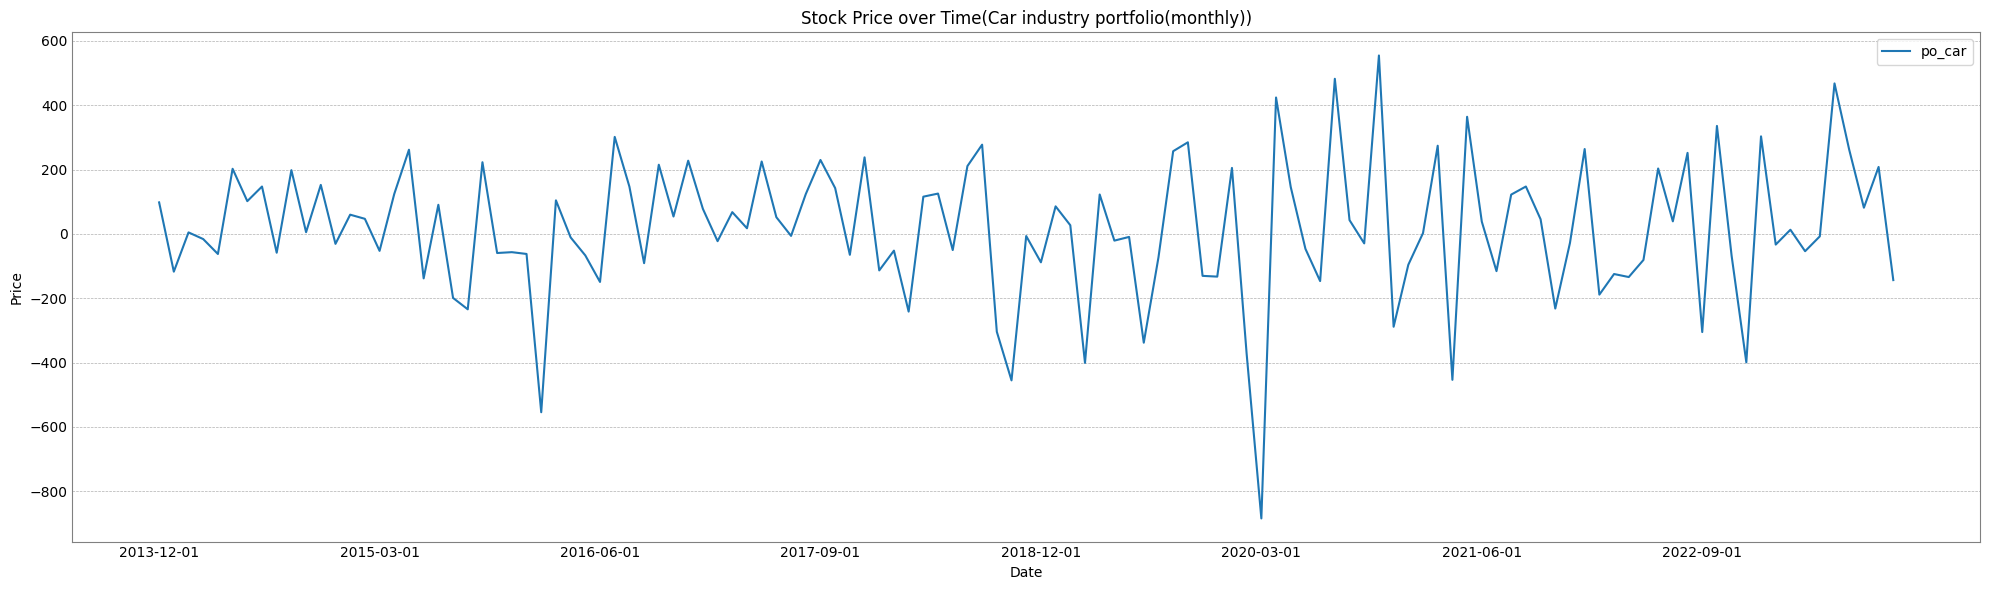

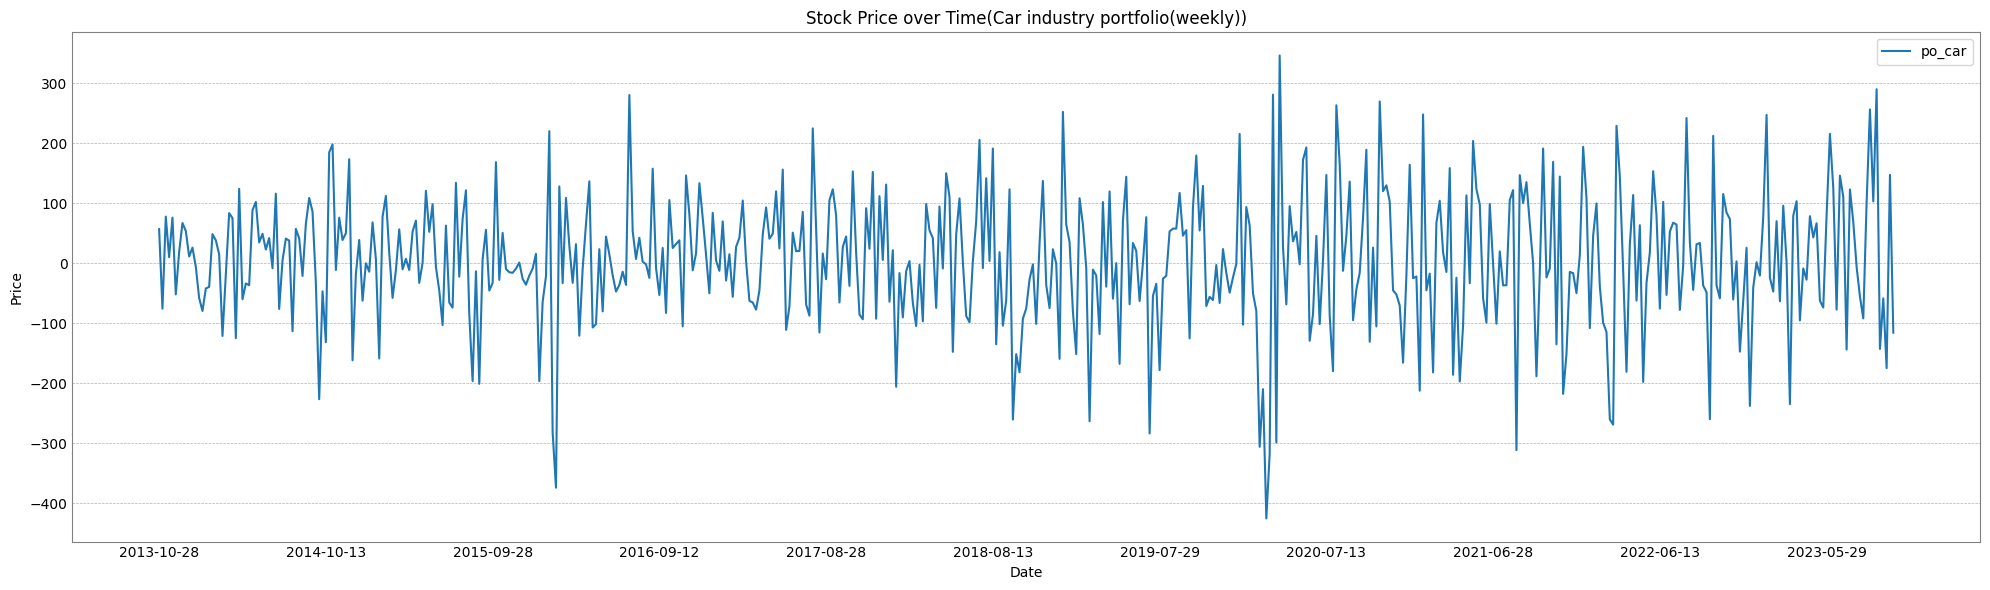

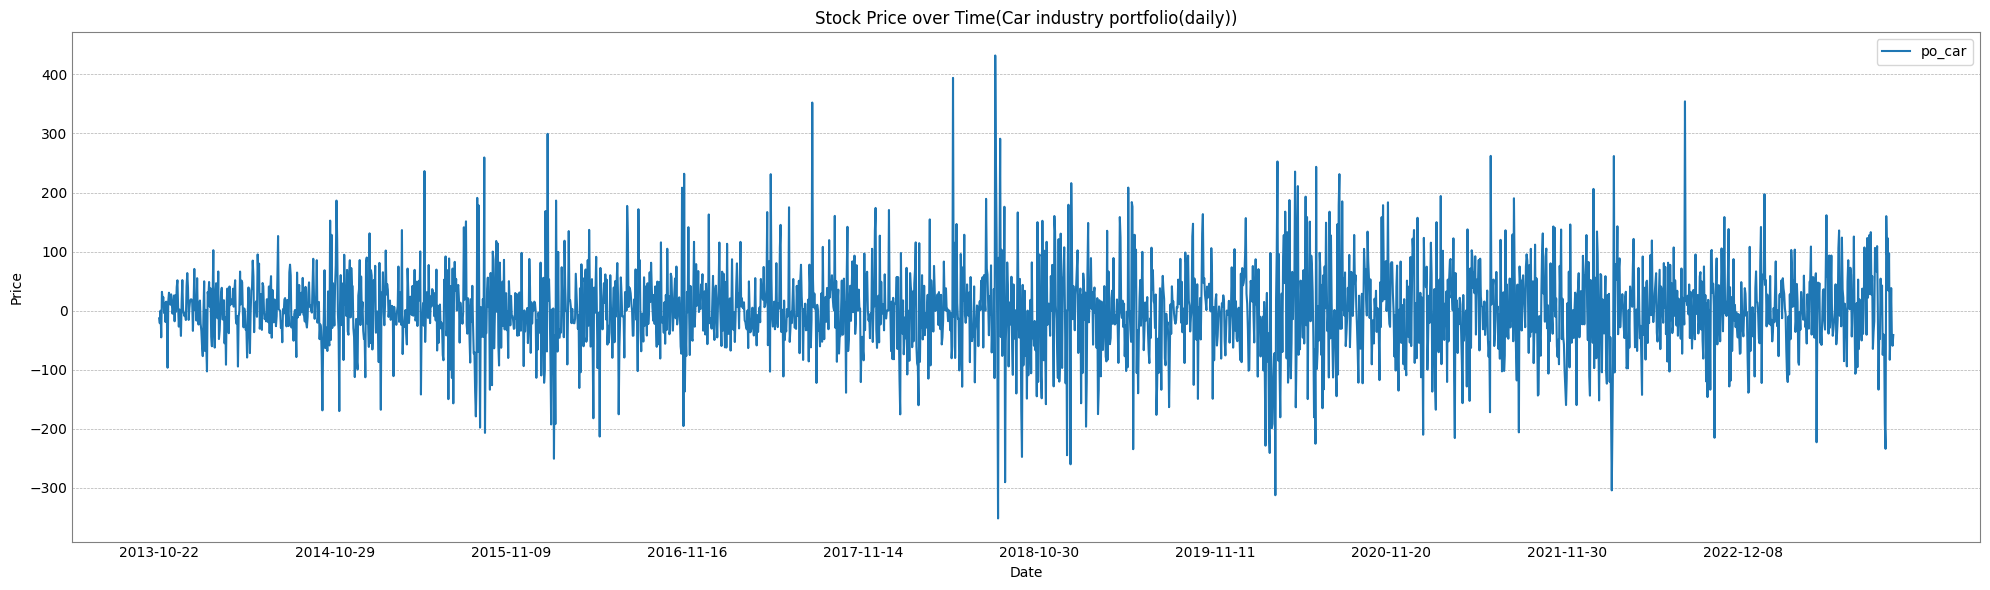

In [138]:
# 差分による非定常性の排除
_temp = ALL_DATA['dataframe']['portfolio_df']['df_mo'].copy()
df_mo_diff = remove_trend(_temp)
_temp = ALL_DATA['dataframe']['portfolio_df']['df_we'].copy()
df_we_diff = remove_trend(_temp)
_temp = ALL_DATA['dataframe']['portfolio_df']['df_da'].copy()
df_da_diff = remove_trend(_temp)

# 線グラフの表示
plot_stock_prices('Car industry portfolio(monthly)', df_mo_diff, ['po_car'])
plot_stock_prices('Car industry portfolio(weekly)', df_we_diff, ['po_car'])
plot_stock_prices('Car industry portfolio(daily)', df_da_diff, ['po_car'])

In [139]:
# ADF検定の結果表示：差分処理後
a = perform_adf_test('Car(Monthly)', df_mo_diff['po_car'])
b = perform_adf_test('Car(Weekly)', df_we_diff['po_car'])
c = perform_adf_test('Car(Daiy)', df_da_diff['po_car'])
result_adf = pd.concat([a, b, c], axis=0, ignore_index=True)
print('differenciated car industry portofolio ADF')
result_adf

differenciated car industry portofolio ADF


ADF Test Statistic       P-Value  # Lags Used  # Observations  \
0           -9.533292  2.852568e-16            1             117   
1          -22.913143  0.000000e+00            0             520   
2          -49.801016  0.000000e+00            0            2464   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)      Result  
0            -3.487517            -2.886578             -2.580124  Stationary  
1            -3.442988            -2.867114             -2.569739  Stationary  
2            -3.433007            -2.862714             -2.567395  Stationary

In [140]:
# ADF検定の結果表示：差分処理後
a = perform_adf_test('Car(Monthly)', df_mo_diff['po_material'])
b = perform_adf_test('Car(Weekly)', df_we_diff['po_material'])
c = perform_adf_test('Car(Daiy)', df_da_diff['po_material'])
result_adf = pd.concat([a, b, c], axis=0, ignore_index=True)
print('differenciated material industry portofolio ADF')
result_adf

differenciated material industry portofolio ADF


ADF Test Statistic       P-Value  # Lags Used  # Observations  \
0          -11.884333  6.073427e-22            0             118   
1          -24.035260  0.000000e+00            0             520   
2          -47.728984  0.000000e+00            0            2464   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)      Result  
0            -3.487022            -2.886363             -2.580009  Stationary  
1            -3.442988            -2.867114             -2.569739  Stationary  
2            -3.433007            -2.862714             -2.567395  Stationary

In [ ]:
# 差分による非定常性の排除
_temp = ALL_DATA['dataframe']['portfolio_df']['df_mo'].copy()
df_mo_diff = remove_trend(_temp)
_temp = ALL_DATA['dataframe']['portfolio_df']['df_we'].copy()
df_we_diff = remove_trend(_temp)
_temp = ALL_DATA['dataframe']['portfolio_df']['df_da'].copy()
df_da_diff = remove_trend(_temp)

# 線グラフの表示
plot_stock_prices('Material industry portfolio(monthly)', df_mo_diff, ['po_material'])
plot_stock_prices('Material industry portfolio(weekly)', df_we_diff, ['po_material'])
plot_stock_prices('Material industry portfolio(daily)', df_da_diff, ['po_material'])

# ADF検定の結果表示：差分処理後
a = perform_adf_test('Material(Monthly)', df_mo_diff['po_material'])
b = perform_adf_test('Material(Weekly)', df_we_diff['po_material'])
c = perform_adf_test('Material(Daiy)', df_da_diff['po_material'])
result_adf = pd.concat([a, b, c], axis=0, ignore_index=True)
result_adf

#### logによる非定常性の排除

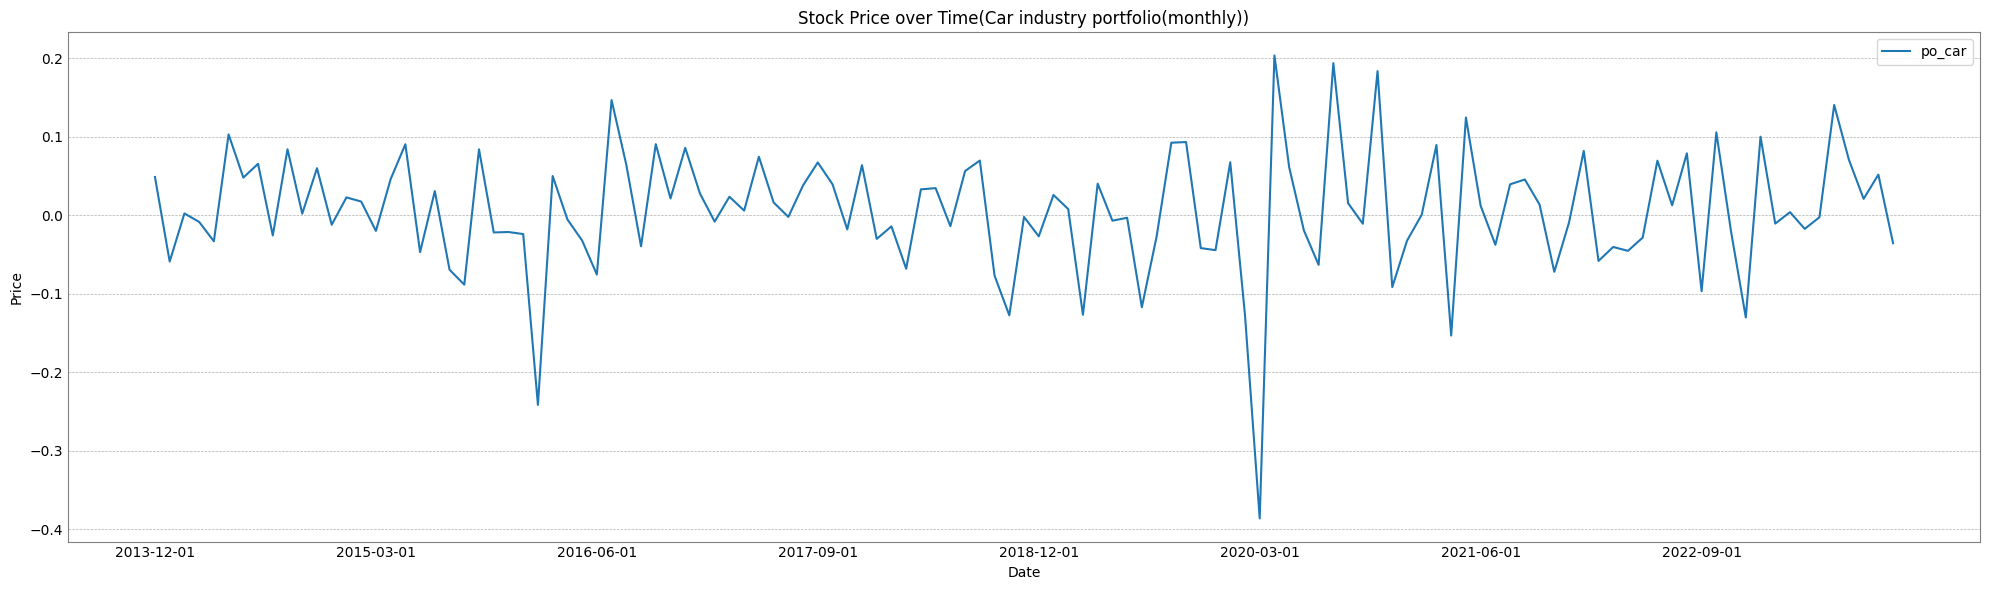

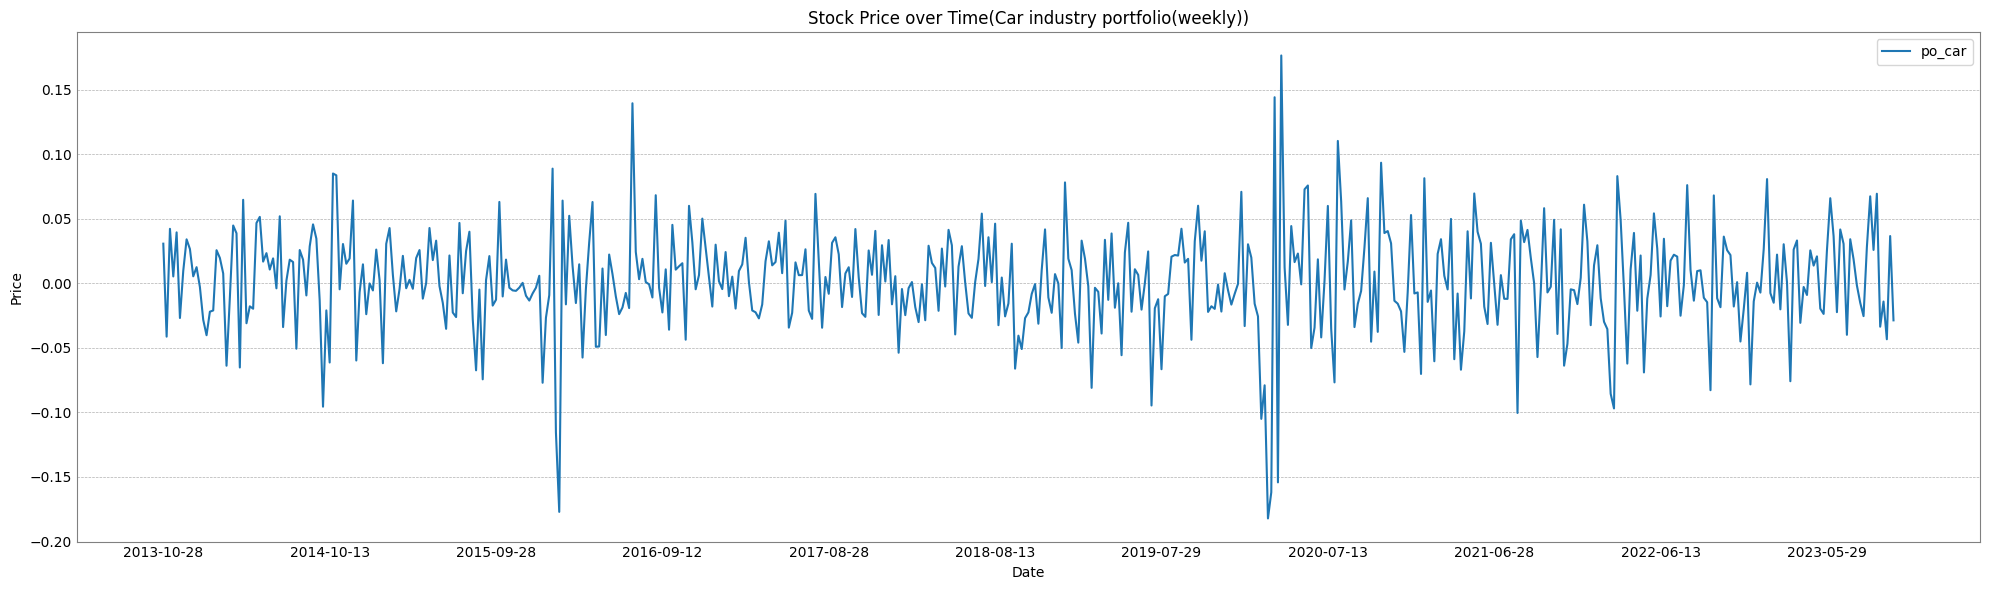

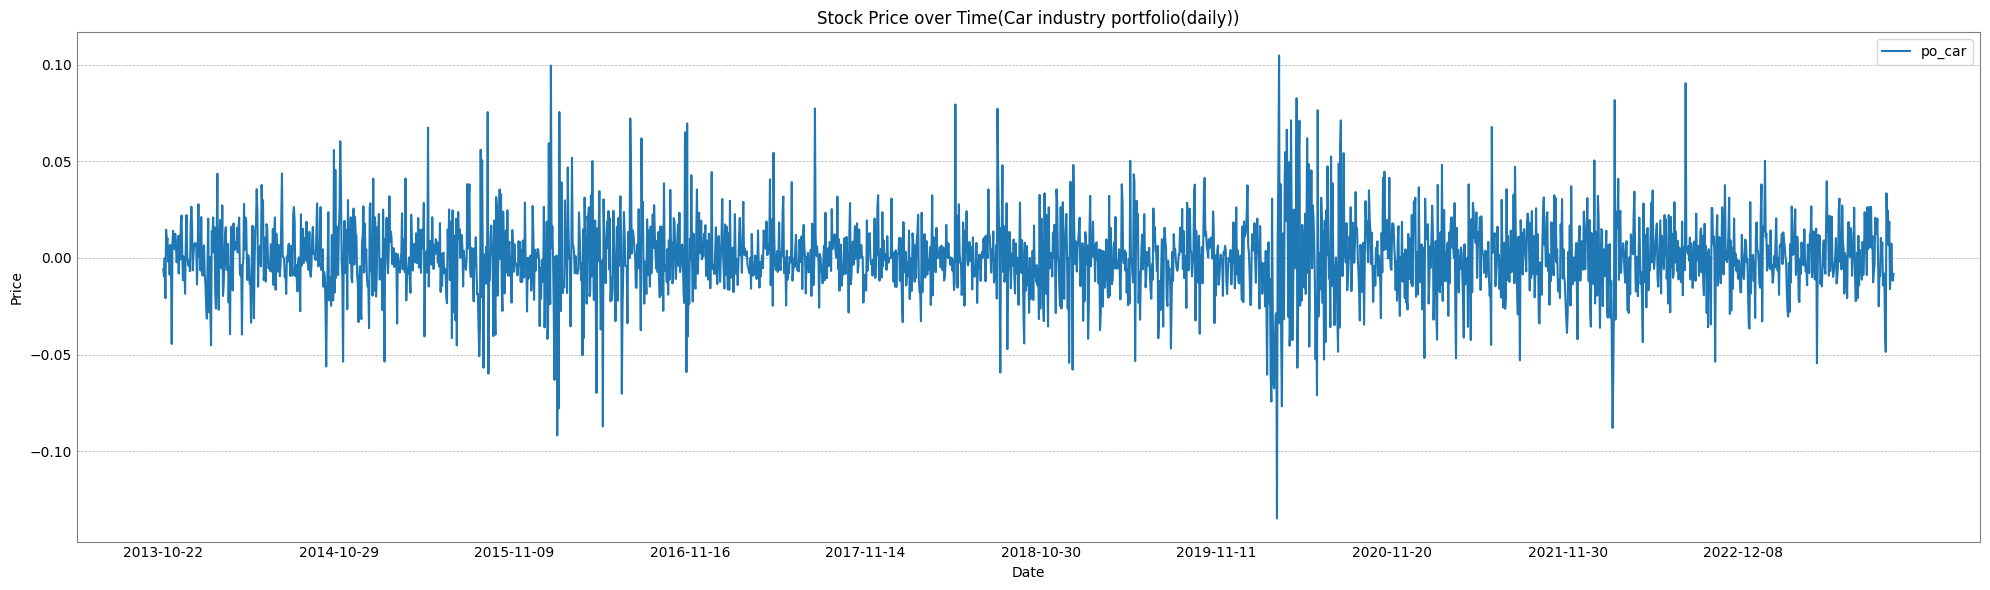

In [141]:
# 対数差分を取得する
_temp = ALL_DATA['dataframe']['portfolio_df']['df_mo'].copy()
df_mo_log = log_difference(_temp)
_temp = ALL_DATA['dataframe']['portfolio_df']['df_we'].copy()
df_we_log = log_difference(_temp, )
_temp = ALL_DATA['dataframe']['portfolio_df']['df_da'].copy()
df_da_log = log_difference(_temp, )

# 線グラフを表示
plot_stock_prices('Car industry portfolio(monthly)', df_mo_log, ['po_car'])
plot_stock_prices('Car industry portfolio(weekly)', df_we_log, ['po_car'])
plot_stock_prices('Car industry portfolio(daily)', df_da_log, ['po_car'])

In [142]:
# ADF検定の結果表示
a = perform_adf_test('TOYOTA(Monthly)', df_mo_log['po_car'])
b = perform_adf_test('TOYOTA(Weekly)', df_we_log['po_car'])
c = perform_adf_test('TOYOTA(Daiy)', df_da_log['po_car'])
result_adf = pd.concat([a, b, c], axis=0, ignore_index=True)
print('Log transformed car industry portofolio ADF')
result_adf

ADF Test Statistic       P-Value  # Lags Used  # Observations  \
0           -9.746709  8.219058e-17            1             117   
1          -23.543806  0.000000e+00            0             520   
2          -34.201612  0.000000e+00            1            2463   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)      Result  
0            -3.487517            -2.886578             -2.580124  Stationary  
1            -3.442988            -2.867114             -2.569739  Stationary  
2            -3.433008            -2.862714             -2.567395  Stationary

In [143]:
# ADF検定の結果表示
a = perform_adf_test('TOYOTA(Monthly)', df_mo_log['po_material'])
b = perform_adf_test('TOYOTA(Weekly)', df_we_log['po_material'])
c = perform_adf_test('TOYOTA(Daiy)', df_da_log['po_material'])
result_adf = pd.concat([a, b, c], axis=0, ignore_index=True)
print('Log transformed material industry portofolio ADF')
result_adf

Log transformed material industry portofolio ADF


ADF Test Statistic       P-Value  # Lags Used  # Observations  \
0          -11.595090  2.732681e-21            0             118   
1          -24.119254  0.000000e+00            0             520   
2          -47.787161  0.000000e+00            0            2464   

   Critical Value (1%)  Critical Value (5%)  Critical Value (10%)      Result  
0            -3.487022            -2.886363             -2.580009  Stationary  
1            -3.442988            -2.867114             -2.569739  Stationary  
2            -3.433007            -2.862714             -2.567395  Stationary

## 1.5: VARでの分析

### 1.5.1: データセットの作成

In [237]:
df_mo_diff = remove_trend(df_mo.copy())
df_we_diff = remove_trend(df_we.copy())
df_da_diff = remove_trend(df_da.copy())

df_mo_log = log_difference(df_mo.copy())
df_we_log = log_difference(df_we.copy())
df_da_log = log_difference(df_da.copy())

stationary_dfs = {
    'diff_dfs': {
      'df_mo': df_mo_diff,
      'df_we': df_we_diff,
      'df_da': df_da_diff,
    },
    'log_dfs': {
      'df_mo': df_mo_log,
      'df_we': df_we_log,
      'df_da': df_da_log
    }
  }

In [238]:
df_we_log

Date    1925.T    1928.T    2413.T    2502.T    2503.T    2802.T  \
1    2013-10-28  0.021087  0.026609 -0.022249  0.010550 -0.003503  0.000738   
2    2013-11-04 -0.028037 -0.019890 -0.032324  0.011182  0.014629  0.029810   
3    2013-11-11  0.041508  0.029328 -0.043396  0.027419  0.059729  0.044140   
4    2013-11-18  0.008711  0.005045  0.080751 -0.006512  0.022545  0.002738   
5    2013-11-25  0.015190  0.015692  0.031158  0.017630  0.005083 -0.002053   
..          ...       ...       ...       ...       ...       ...       ...   
517  2023-09-18 -0.025781 -0.045507 -0.035945 -0.040297 -0.005897 -0.039921   
518  2023-09-25 -0.020218 -0.010027 -0.010985 -0.022115 -0.009747 -0.009497   
519  2023-10-02 -0.004243 -0.051170 -0.021398 -0.013689 -0.003110  0.023321   
520  2023-10-09  0.003496  0.006168 -0.025139  0.008667  0.005258 -0.006462   
521  2023-10-16 -0.007506  0.007003 -0.077362 -0.051842 -0.012473 -0.051994   

       2914.T    3382.T    3402.T    3407.T    4063.T    4188.T    4452.T  \
1    0.070993  0.005587  0.004946  0.053038  0.003643 -0.008969  0.039656   
2   -0.032697 -0.018272  0.072932 -0.001325  0.016231 -0.004515 -0.015674   
3    0.060285  0.061875  0.016680  0.041564  0.060730  0.061423  0.074559   
4   -0.013699 -0.002670  0.083622  0.018904 -0.006757 -0.002130 -0.005882   
5   -0.046586  0.007989  0.001382  0.008701  0.003384  0.014815 -0.007402   
..        ...       ...       ...       ...       ...       ...       ...   
517  0.027521 -0.025284 -0.028963 -0.021111 -0.036572 -0.018480 -0.043768   
518  0.004078 -0.007148 -0.040184 -0.036561 -0.043701 -0.017873  0.025914   
519 -0.040640 -0.011336 -0.059581 -0.034089 -0.014846 -0.059213 -0.008321   
520  0.030707 -0.051211  0.007611  0.030358  0.047688  0.018179 -0.022411   
521  0.004979 -0.050911 -0.016793 -0.012573 -0.043490 -0.056379  0.011268   

       4502.T    4503.T    4507.T    4519.T    4523.T    4528.T    4543.T  \
1    0.017242  0.038786  0.028252  0.072561  0.018159  0.156711  0.009746   
2    0.001068  0.040822  0.026097 -0.017208  0.003849  0.080365  0.034943   
3    0.024250  0.063995  0.052856  0.060860  0.020280  0.003854  0.084754   
4    0.012423 -0.029804  0.018159  0.012898 -0.010088 -0.002567  0.020814   
5    0.023387  0.019967 -0.035765  0.010691  0.013845 -0.002574  0.001871   
..        ...       ...       ...       ...       ...       ...       ...   
517 -0.031138 -0.059726 -0.021123 -0.063140 -0.057741 -0.023247 -0.068863   
518 -0.014970 -0.010552  0.012189  0.084341 -0.020855 -0.000697 -0.036422   
519 -0.034414 -0.021443 -0.026216 -0.041958 -0.011384 -0.030265 -0.025816   
520  0.013732 -0.027467  0.042534  0.057196  0.002798  0.004482 -0.014344   
521 -0.043612 -0.048233  0.028575 -0.031811 -0.018140 -0.060278  0.016155   

       4568.T    4578.T    4661.T    4689.T    4901.T    4911.T    5020.T  \
1    0.016306  0.020619  0.015646 -0.141260  0.064122 -0.032403  0.004073   
2    0.039371 -0.001094 -0.012366  0.070983  0.001250 -0.005404  0.028058   
3    0.026457  0.005458 -0.005253  0.004274  0.059792  0.061863  0.029213   
4   -0.029679  0.007231 -0.006605  0.055973  0.023257 -0.014249  0.003831   
5    0.011233  0.074931  0.000000 -0.004040  0.069197  0.005724  0.018940   
..        ...       ...       ...       ...       ...       ...       ...   
517 -0.057915 -0.038788 -0.033664 -0.079296 -0.034003 -0.054506 -0.020949   
518  0.053783 -0.004132 -0.028912  0.008459 -0.021595 -0.026503 -0.047829   
519 -0.035448 -0.039349 -0.001835 -0.030794 -0.014894 -0.010147 -0.122285   
520  0.033498  0.015733 -0.020619  0.006432  0.033319 -0.037444  0.044585   
521 -0.000732 -0.041111 -0.047354 -0.058915 -0.040378 -0.060737  0.034573   

       5108.T    5401.T    5713.T    5802.T    6273.T    6301.T    6326.T  \
1   -0.017991 -0.042951 -0.009626  0.011761  0.037421 -0.085825 -0.004863   
2    0.037124 -0.006289 -0.014238 -0.018744 -0.006140 -0.009050  0.056849   
3    0.046984  0.046233  0.046451  0.084614  0.015714  0

VARモデルの適応

In [249]:
_temp_car_ticker = ALL_DATA['tickers']['category_tc']['automotive_transport_equipment']
_temp_car_df_mo = stationary_dfs['log_dfs']['df_mo']
_temp_car_df_we = stationary_dfs['log_dfs']['df_we']
_temp_car_df_da = stationary_dfs['log_dfs']['df_da']

_temp_material_ticker = ALL_DATA['tickers']['category_tc']['materials']
_temp_material_df_mo = stationary_dfs['log_dfs']['df_mo']
_temp_material_df_we = stationary_dfs['log_dfs']['df_we']
_temp_material_df_da = stationary_dfs['log_dfs']['df_da']

fitted_model = create_var_model(_temp_material_df_we[_temp_material_ticker])
print(fitted_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Oct, 2023
Time:                     02:53:10
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.7922
Nobs:                     519.000    HQIC:                  -26.8121
Log likelihood:           4019.35    FPE:                2.23914e-12
AIC:                     -26.8249    Det(Omega_mle):     2.22196e-12
--------------------------------------------------------------------
Results for equation 5401.T
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000048         0.002056            0.023           0.981

Results for equation 5713.T
           coefficient       std. error           t-stat            prob
--------------------------------------------------------------

In [245]:
def plot_var_forecast_for_target(data, target='7203.T', forecast_steps=10):
    """
    VARモデルを用いて特定のターゲット変数の予測をグラフで表示する関数
    
    Parameters:
    - data (pd.DataFrame): VARモデルの入力データ
    - target (str): 予測対象のカラム名
    - forecast_steps (int): 予測を行うステップ数
    
    Returns:
    None (グラフを表示する)
    """
    
    # VARモデルをデータに適用
    model = VAR(data)
    fitted_model = model.fit()

    # 予測の生成
    forecast = fitted_model.forecast(data.values[-fitted_model.k_ar:], steps=forecast_steps)
    forecast_df = pd.DataFrame(forecast, columns=data.columns)

    # 予測結果のグラフ表示
    plt.figure(figsize=(10, 6))
    plt.plot(data[target], label='Actual', color='blue')
    plt.plot(np.arange(len(data), len(data) + forecast_steps), forecast_df[target], label='Forecast', color='red')
    plt.title(f'Forecast for {target}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 使用例:
# data = pd.DataFrame({
#     '7203.T': np.random.randn(100),
#     '7201.T': np.random.randn(100)
# })
# plot_var_forecast_for_target(data, target='7203.T', forecast_steps=30)

In [246]:
_temp_car_df_we.shape

(519, 99)

In [2]:
# 7203.Tの予測とグラフ表示を実行
plot_var_forecast_for_target(_temp_car_df_we[_temp_car_ticker], target='7203.T', forecast_steps=25)


NameError: name 'plot_var_forecast_for_target' is not defined

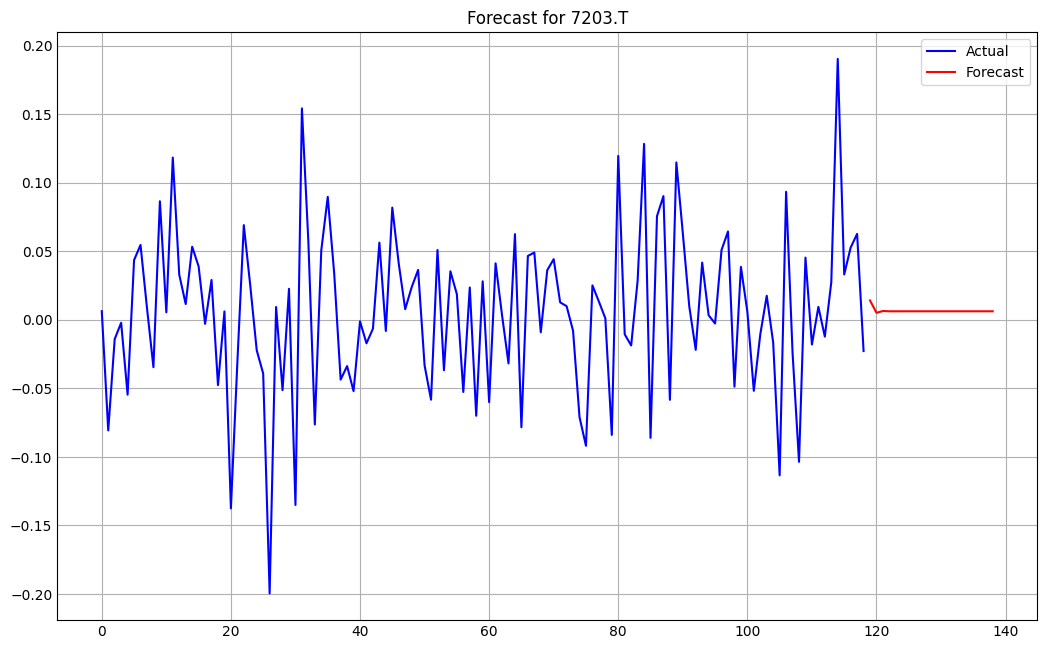

In [228]:
# 最後の120行のみを残す
_temp = _temp_car_df_we[_temp_car_ticker].copy().reset_index(drop=True)

plot_var_forecast_for_target(_temp, target='7203.T', forecast_steps=20)

In [224]:
_temp.describe()

7201.T      7203.T      7267.T      7269.T      7270.T
count  119.000000  119.000000  119.000000  119.000000  119.000000
mean    -0.003724    0.006036    0.001032    0.006629   -0.000629
std      0.085927    0.060417    0.069851    0.098742    0.081729
min     -0.262407   -0.199637   -0.202842   -0.517651   -0.272964
25%     -0.048562   -0.031535   -0.039606   -0.036626   -0.051144
50%     -0.011294    0.008674    0.000000    0.004939    0.005631
75%      0.043407    0.042557    0.050808    0.071543    0.052180
max      0.296861    0.190280    0.164888    0.294334    0.204462